

Classifying Common Thoracic Diseases with <br>
Augmented Pediatric Chest X-ray Dataset

---


Halil İbrahim Dönmezbilek <br>





# Data Source

P. H. Huy, T. T. Thanh and N. H. Quy, "VinDr-PCXR: An open, large-scale pediatric chest X-ray dataset for interpretation of common thoracic diseases," PhysioNet, March 2022.

The Original Dataset Available From:
>https://physionet.org/content/vindr-pcxr/1.0.0/

# Pips

In [ ]:
!pip install optuna
!pip install pydicom
!pip install SimpleITK
!pip install ultralytics
!apt-get install p7zip-full
!pip install albumentations
!pip install torch torchvision
!pip install iterative-stratification
!pip install pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 701.1/701.1 kB 6.3 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 62.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installa

# Imports & Seed

>After installing packages you may need to restart the session to import packages properly.

**Preprocessing Imports**

In [ ]:
import os
import cv2
import glob
import json
import uuid
import yaml
import shutil
import pydicom
import requests
import subprocess
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import SimpleITK as sitk
import albumentations as A
from itertools import cycle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

**AI Modelling Imports**

In [ ]:
import torch
import optuna
import logging
import torch.nn as nn
import torch.optim as optim
from ultralytics import YOLO, settings
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_pil_image
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc

**General**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set the global seed for reproducibility
seed = 2649614
np.random.seed(seed)

# Preprocessing and Augmentation Part - On Local Computer

In [ ]:
base_path = "E:\\vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0"

image_labels_train = pd.read_csv(os.path.join(base_path, 'image_labels_train.csv'))
image_annotations_train = pd.read_csv(os.path.join(base_path, 'annotations_train.csv'))
image_annotations_train['image_path'] = image_annotations_train['image_id'].apply(lambda x: f"{'train/'}{x}.dicom")

image_labels_test = pd.read_csv(os.path.join(base_path, 'image_labels_test.csv'))
image_annotations_test = pd.read_csv(os.path.join(base_path, 'annotations_test.csv'))
image_annotations_test['image_path'] = image_annotations_test['image_id'].apply(lambda x: f"{'test/'}{x}.dicom")


In [ ]:
##### Preprocess of The Data
tqdm.pandas()
def initial_preprocess(label_df, annotation_df):

    def convert_to_yolo_format(row):
        image_file_path = os.path.join(base_path,row['image_path'])
        ds = pydicom.dcmread(image_file_path, stop_before_pixels=True)
        image_width = ds.Columns
        image_height = ds.Rows
        try:
            sex = ds.PatientSex
            age = ds.PatientAge
        except: #If there are no information about the age, it will None value.
            sex = None
            age = None

        x_center = (row['x_min'] + row['x_max']) / 2
        y_center = (row['y_min'] + row['y_max']) / 2
        width = row['x_max'] - row['x_min']
        height = row['y_max'] - row['y_min']

        # Normalize the values
        x_center /= image_width
        y_center /= image_height
        width /= image_width
        height /= image_height

        return [image_width, image_height, x_center, y_center, width, height, sex, age]

    yolo_format_annotations_other_features = annotation_df.progress_apply(convert_to_yolo_format, axis=1)
    annotation_df = annotation_df.join(pd.DataFrame(yolo_format_annotations_other_features.tolist(), columns=['image_width', 'image_height',  'x_center', 'y_center', 'width', 'height', 'sex', 'age']))
    df = pd.merge(annotation_df, label_df[['image_id','No finding', 'Bronchitis', 'Brocho-pneumonia',
        'Other disease', 'Bronchiolitis', 'Situs inversus', 'Pneumonia',
        'Pleuro-pneumonia', 'Diagphramatic hernia', 'Tuberculosis',
        'Congenital emphysema', 'CPAM', 'Hyaline membrane disease',
        'Mediastinal tumor', 'Lung tumor']], on='image_id', how='left')

    return df

train_df = initial_preprocess(image_labels_train, image_annotations_train)
test_df = initial_preprocess(image_labels_test, image_annotations_test)

# Add 'TVT' column, abbrevation for Train,Validation and Test
train_df['TVT'] = 'train'
test_df['TVT'] = 'test'
main_df = pd.concat([train_df, test_df], ignore_index=True)

yolo_class_id_mapping = {'Boot-shaped heart': 0,
        'Peribronchovascular interstitial opacity': 1,
        'Reticulonodular opacity': 2,
        'Bronchial thickening': 3,
        'Enlarged PA': 4,
        'Cardiomegaly': 5,
        'Diffuse aveolar opacity': 6,
        'Other opacity': 7,
        'Other lesion': 8,
        'Consolidation': 9,
        'Mediastinal shift': 10,
        'Anterior mediastinal mass': 11,
        'Dextro cardia': 12,
        'Pleural effusion': 13,
        'Stomach on the right side': 14,
        'Atelectasis': 15,
        'Lung hyperinflation': 16,
        'Egg on string sign': 17,
        'Interstitial lung disease - ILD': 18,
        'Infiltration': 19,
        'Lung cavity': 20,
        'Pneumothorax': 21,
        'Edema': 22,
        'Pleural thickening': 23,
        'Other nodule/mass': 24,
        'Clavicle fracture': 25,
        'Chest wall mass': 26,
        'Lung cyst': 27,
        'Emphysema': 28,
        'Bronchectasis': 29,
        'Expanded edges of the anterior ribs': 30,
        'Pulmonary fibrosis': 31,
        'Paraveterbral mass': 32,
        'Aortic enlargement': 33,
        'Calcification': 34,
        'Intrathoracic digestive structure': 35
        }
main_df['YOLO_class_name'] = main_df['class_name'].map(yolo_class_id_mapping)

train_df = main_df[main_df['TVT'] == 'train']

label_cols = ['No finding', 'Bronchitis',
       'Brocho-pneumonia', 'Other disease', 'Bronchiolitis', 'Situs inversus',
       'Pneumonia', 'Pleuro-pneumonia', 'Diagphramatic hernia', 'Tuberculosis',
       'Congenital emphysema', 'CPAM', 'Hyaline membrane disease',
       'Mediastinal tumor', 'Lung tumor']
labels = train_df[label_cols].values

# Initialize the MultilabelStratifiedShuffleSplit
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=seed)

# Splitting the dataset into the Training and Validation sets
for train_index, val_index in msss.split(np.zeros(len(train_df)), labels):
    train_subset = train_df.iloc[train_index]
    val_subset = train_df.iloc[val_index]

# Update the 'TVT' column in the original dataframe
main_df.loc[train_subset.index, 'TVT'] = 'train'
main_df.loc[val_subset.index, 'TVT'] = 'validation'

#### Dealing with age and normalizing it.
def age_to_days(age_str):
    if pd.isna(age_str) or age_str in ['None', '']:
        return None
    try:
        age_value = int(age_str[:-1])
        age_unit = age_str[-1]

        if age_unit == 'D':
            return age_value
        elif age_unit == 'M':
            return age_value * 30  # Approximating 1 month as 30 days
        elif age_unit == 'Y':
            return age_value * 365  # Approximating 1 year as 365 days
    except ValueError:
        # Handle cases where conversion to int fails
        return None
    return None

main_df['age_in_days'] = main_df['age'].apply(age_to_days)
mean_age_days = main_df['age_in_days'].dropna().mean()
# Fill missing values in 'age_in_days' with the mean
main_df['age_in_days'].fillna(mean_age_days, inplace=True)
# Normalize the age values
max_age = main_df['age_in_days'].max()
min_age = main_df['age_in_days'].min()
main_df['normalized_age'] = (main_df['age_in_days'] - min_age) / (max_age - min_age)

# Dealing with sex and encoding.
mode_sex = main_df['sex'].mode()[0]
main_df['sex'].fillna(mode_sex, inplace=True)
# Encode 'sex' column: 1 for male, 0 for others
main_df['normalized_sex'] = main_df['sex'].apply(lambda x: 1 if x == 'M' else 0)

# Create directories for images and labels
os.makedirs(os.path.join(base_path, 'data/images/train'), exist_ok=True)
os.makedirs(os.path.join(base_path, 'data/images/val'), exist_ok=True)
os.makedirs(os.path.join(base_path, 'data/images/test'), exist_ok=True)


os.makedirs(os.path.join(base_path, 'data/labels/train'), exist_ok=True)
os.makedirs(os.path.join(base_path, 'data/labels/val'), exist_ok=True)
os.makedirs(os.path.join(base_path, 'data/labels/test'), exist_ok=True)


main_df.to_csv(os.path.join(base_path, 'data/main_df.csv'))

100%|██████████| 1850/1850 [00:21<00:00, 85.66it/s]


In [ ]:
train_df = main_df[main_df['TVT'] == 'train']
val_df = main_df[main_df['TVT'] == 'validation']
test_df = main_df[main_df['TVT'] == 'test']

def converting_to_jpeg(df, folder):
    def convert_dicom_to_jpeg(dicom_path, jpeg_path):
        """Converts a DICOM file to a JPEG file."""
        try:
            sitk_image = sitk.ReadImage(dicom_path)
            array = sitk.GetArrayFromImage(sitk_image)

            # Handle multi-frame DICOM files
            if array.ndim > 2:
                # Select the first frame
                array = array[0]

            # Normalize and scale to 8-bit
            array = array.astype(float)
            array -= array.min()
            array /= array.max()
            array *= 255.0
            array = array.astype(np.uint8)

            image = Image.fromarray(array)
            image.save(jpeg_path)
        except Exception as e:
            print(f"Error converting file {dicom_path}: {e}")


    for _, row in tqdm(df.iterrows(), total=df.shape[0], desc=f"Converting {folder} images to JPEG"):
        jpeg_path = os.path.join(base_path, f'data/images/{folder}', row['image_id'] + '.jpg')
        if not os.path.exists(jpeg_path):
            convert_dicom_to_jpeg(os.path.join(base_path, row['image_path']), jpeg_path)

converting_to_jpeg(train_df, 'train')
converting_to_jpeg(val_df, 'val')
converting_to_jpeg(test_df, 'test')

Converting test images to JPEG: 100%|██████████| 1850/1850 [06:24<00:00,  4.81it/s]


In [ ]:
#### Augmentation Pipeline
##Referance:
## M. Elgendi et al., “The Effectiveness of image augmentation in deep learning networks for detecting COVID-19: A Geometric Transformation perspective,” Frontiers in Medicine, vol. 8, Mar. 2021, doi: 10.3389/fmed.2021.629134.

# augmentation1 = A.Compose([
#     A.Rotate(limit=15, p=0.7),  # Rotate within [-15, 15] degrees | ‘‘RandRotation,’’[-15 15],
#     A.RandomScale(scale_limit=0.3, p=0.7),  # Scale between 85% (0.85) and 115% (1.15) | ‘‘RandScale,’’[0.85 1.15],
#     A.HorizontalFlip(p=0.5),  # Horizontal flipping | ‘‘RandYReflection,’’true,
#     A.Affine(shear={'x': (-15, 15), 'y': (-15, 15)}, p=0.7),  # Shear by [-15, 15] degrees in x and y | ‘‘RandXShear,’’[-floor(0.1*inputSize)floor(0.1*inputSize)] and ‘‘RandYShear,’’[-floor(0.1*inputSize)floor(0.1*inputSize)],
#     A.ShiftScaleRotate(shift_limit=0.15, scale_limit=0.15, rotate_limit=0, p=0.7)  # Translation within [-15%, 15%] of image size | ‘‘RandXTranslation,’’[-floor(0.15*inputSize)floor(0.15*inputSize)] and ‘‘RandYTranslation,’’[-floor(0.15*inputSize)floor(0.15*inputSize)]
# ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

# augmentation2 = A.Compose([
#     A.Rotate(limit=90, p=0.7),  # Rotate within [-90, 90] degrees | ‘‘RandRotation,’’[-90 90],
#     A.Affine(shear={'x': (-30, 30), 'y': (-30, 30)}, p=0.7),  # Shear by [-30, 30] degrees in x and y | ‘‘RandXShear,’’[-30 30] and ‘‘RandYShear,’’[-30 30]
#     A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=0, p=0.7)  # Translation within [-10%, 10%] of image size | ‘‘RandXTranslation,’’[-10 10] and ‘‘RandYTranslation,’’[-10 10]
# ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

# augmentation3 = A.Compose([
#     A.Rotate(limit=30, p=0.7),  # Rotate within [-30, 30] degrees | ‘‘RandRotation,’’[-30 30]
#     A.HorizontalFlip(p=0.5)  # Horizontal flipping | ‘‘RandYReflection,’’true'
# ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

augmentation4 = A.Compose([
    A.Rotate(limit=10, p=0.7),  # Rotate within [-10, 10] degrees | ‘‘RandRotation,’’[-10 10]
    A.HorizontalFlip(p=0.5),  # Horizontal flipping | ‘‘RandYReflection,’’true'
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0, rotate_limit=0, p=0.7)  # Translation within [-20%, 20%] of image size | ‘‘RandXTranslation,’’[-floor(0.2*inputSize)floor(0.2*inputSize)] and ‘‘RandYTranslation,’’[-floor(0.2*inputSize)floor(0.2*inputSize)]
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))


# Function to apply the augmentation
def augment_image(image, bboxes, class_labels, pipeline, augmentation_number):
    augmented = pipeline(image=image, bboxes=bboxes, class_labels=class_labels)
    return augmented['image'], augmented['bboxes'], augmentation_number

In [ ]:
augmentation_pipelines = [augmentation4]
new_rows = []
for index, row in tqdm(main_df.iterrows(), total=main_df.shape[0]):
    if row['TVT'] in ['train']:

        # Skip augmentation if class_name is 'No finding
        if row['class_name'] != 'No finding':

            for i, pipeline in enumerate(augmentation_pipelines, start=1):
                type_of_row = 'train' if row['TVT'] == 'train' else 'val'
                image_path = os.path.join(base_path, f'data/images/{type_of_row}', row['image_id'] + '.jpg')

                image = cv2.imread(image_path)
                if image is None:
                    print(f"Failed to load image at path: {image_path}")
                    continue
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

                # Define original bounding boxes and class labels
                original_bboxes = [(row['x_min'], row['y_min'], row['x_max'], row['y_max'])]
                class_labels = [row['class_name']]

                # Apply augmentation
                augmented_image, augmented_bboxes, aug_num = augment_image(image, original_bboxes, class_labels, pipeline, i)

                # Obtain dimensions of the augmented image
                augmented_image_height, augmented_image_width, _ = augmented_image.shape

                new_image_id = str(uuid.uuid4())
                augmented_image_path = os.path.join(base_path, f'data/images/{type_of_row}/{new_image_id}.jpg')
                Image.fromarray(augmented_image).save(augmented_image_path)

                # Add augmented image details to main_df
                for bbox in augmented_bboxes:
                    new_row = row.copy()
                    new_row['image_id'] = new_image_id
                    new_row['image_path'] = f'data/images/{type_of_row}', row['image_id'] + '.jpg'
                    new_row['x_min'] = bbox[0]
                    new_row['y_min'] = bbox[1]
                    new_row['x_max'] = bbox[2]
                    new_row['y_max'] = bbox[3]

                    # Recalculate the center, width, and height for the new bounding box
                    new_row['x_center'] = (bbox[0] + bbox[2]) / 2
                    new_row['y_center'] = (bbox[1] + bbox[3]) / 2
                    new_row['width'] = bbox[2] - bbox[0]
                    new_row['height'] = bbox[3] - bbox[1]

                    # Normalize the values using augmented image dimensions
                    new_row['x_center'] = round(new_row['x_center'] / augmented_image_width, 6)
                    new_row['y_center'] = round(new_row['y_center'] / augmented_image_height, 6)
                    new_row['width'] = round(new_row['width'] / augmented_image_width, 6)
                    new_row['height'] = round(new_row['height'] / augmented_image_height, 6)

                    new_row['TVT'] = f"{row['TVT']}_augmentation"
                    new_rows.append(new_row)

main_df = pd.concat([main_df, pd.DataFrame(new_rows)], ignore_index=True)
main_df.to_csv(os.path.join(base_path, 'data/main_df_augmented.csv'))

100%|██████████| 12221/12221 [06:56<00:00, 29.37it/s]  


In [ ]:
train_df_for_label = main_df[((main_df['TVT'] == 'train_augmentation') | (main_df['TVT'] == 'train')) & main_df['YOLO_class_name'].notna()]
val_df_for_label = main_df[((main_df['TVT'] == 'validation_augmentation') | (main_df['TVT'] == 'validation')) & main_df['YOLO_class_name'].notna()]
test_df_for_label = main_df[((main_df['TVT'] == 'test')) & main_df['YOLO_class_name'].notna()]

def create_label_files(df, label_dir):

    os.makedirs(label_dir, exist_ok=True)

    label_data = {}
    file_count = 0
    total_label_lines = 0

    for _, row in df.iterrows():
        label_file = os.path.join(label_dir, row['image_id'] + '.txt')
        label_line = f"{row['YOLO_class_name']} {row['x_center']} {row['y_center']} {row['width']} {row['height']}\n"

        if label_file in label_data:
            label_data[label_file].append(label_line)
        else:
            label_data[label_file] = [label_line]
            file_count += 1

    for label_file, lines in label_data.items():
        with open(label_file, 'w') as file:
            file.writelines(lines)
        total_label_lines += len(lines)

    return file_count, total_label_lines

file_count_train, total_label_lines_train = create_label_files(train_df_for_label, os.path.join(base_path, 'data/labels/train'))
file_count_val, total_label_lines_val = create_label_files(val_df_for_label, os.path.join(base_path, 'data/labels/val'))
file_count_test, total_label_lines_test = create_label_files(test_df_for_label, os.path.join(base_path, 'data/labels/test'))
print(f'Number of Annotations: {total_label_lines_train+total_label_lines_val+total_label_lines_test} -  Number of Files: {file_count_train+file_count_val+file_count_test}')

Number of Annotations: 10614 -  Number of Files: 8072


In [ ]:
dataset_yaml = {
    "names": [
        'Boot-shaped heart', 'Peribronchovascular interstitial opacity', 'Reticulonodular opacity',
        'Bronchial thickening', 'Enlarged PA', 'Cardiomegaly', 'Other opacity',
        'Intrathoracic digestive structure', 'Diffuse aveolar opacity', 'Other lesion', 'Consolidation',
        'Mediastinal shift', 'Anterior mediastinal mass', 'Other nodule/mass', 'Dextro cardia',
        'Aortic enlargement', 'Pleural effusion', 'Stomach on the right side', 'Atelectasis', 'Calcification',
        'Interstitial lung disease - ILD', 'Lung hyperinflation', 'Egg on string sign', 'Pulmonary fibrosis',
        'Infiltration', 'Lung cavity', 'Pneumothorax', 'Edema', 'Pleural thickening', 'Clavicle fracture',
        'Chest wall mass', 'Lung cyst', 'Emphysema', 'Bronchectasis', 'Expanded edges of the anterior ribs',
        'Paraveterbral mass'
    ],
    "nc": 36,
    "train": "/content/data/images/train",
    "val": "/content/data/images/val",
    "test": "/content/data/images/test"
}

yaml_file_path = os.path.join(base_path, 'data/dataset.yaml')
with open(yaml_file_path, 'w') as file:
    yaml.dump(dataset_yaml, file, default_flow_style=False)

In [ ]:
# Zip the data folder to upload Google Drive
input_folder = os.path.join(base_path, 'data','*')
output_archive = os.path.join(base_path, 'data_only_augmentation4_method.zip')
path_to_7za = shutil.which("7z")
command = f'"{path_to_7za}" a -tzip "{output_archive}" "{input_folder}"'
subprocess.run(command, check=True, shell=True)

CompletedProcess(args='"C:\\ProgramData\\chocolatey\\bin\\7z.EXE" a -tzip "E:\\vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0\\data_only_augmentation4_method.zip" "E:\\vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0\\data\\*"', returncode=0)

# Unzipping Preprocessed Data

In [ ]:
# To prevent I/O 'time out' issues the zip package is prepared on local computer then uploaded to google drive. This is the unzip part: (Further information: https://research.google.com/colaboratory/faq.html)
# In this way AI models also can much more easly fetch the data
output_dir = '/content/data'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
%cd /content/data
!7za x '/content/drive/MyDrive/DI504 Term Project/data_only_augmentation4_method.zip'

/content/data

7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/DI504 Term Project/                                                    1 file, 2005253751 bytes (1913 MiB)

Extracting archive: /content/drive/MyDrive/DI504 Term Project/data_only_augmentation4_method.zip
 18% 4096 Open              --
Path = /content/drive/MyDrive/DI504 Term Project/data_only_augmentation4_method.zip
Type = zip
Physical Size = 2005253751

  0%      0% 73 - images/test/0c82b56f52a977d94822dd202b18093a.jpg                                                          

# Descriptive Analsis

In [ ]:
df_descriptive = pd.read_csv('/content/data/main_df_augmented.csv').iloc[:,1:]
df_descriptive = df_descriptive.drop_duplicates(subset='image_id', keep='first')

In [ ]:
categories = ['train', 'train_augmentation', 'validation', 'test']
male_value = df_descriptive['normalized_sex'].value_counts().idxmax()
stats_corrected = []

for category in categories:
  # Filter the data for each category
  category_data = df_descriptive[df_descriptive['TVT'] == category]

  # Calculating the number and percentage of male patients
  male_count = category_data[category_data['normalized_sex'] == male_value].shape[0]
  total_count = category_data.shape[0]
  male_percentage = (male_count / total_count) * 100 if total_count > 0 else 0

  # Calculating the number and percentage of female patients
  female_count = total_count - male_count
  female_percentage = 100 - male_percentage if total_count > 0 else 0

  # Calculating the mean age
  mean_age = category_data['age_in_days'].mean()

  stats_corrected.append({
      'Category': category,
      'Male Count': male_count,
      'Female Count': female_count,
      'Male Percentage': male_percentage,
      'Female Percentage': female_percentage,
      'Mean Age (in years)': f'{mean_age / 365:.2f}'
  })

stats_gender_age_df = pd.DataFrame(stats_corrected)
from IPython.display import display, HTML
display(HTML(stats_gender_age_df.to_html(index=False)))


Category,Male Count,Female Count,Male Percentage,Female Percentage,Mean Age (in years)
train,4004,2567,60.934409,39.065591,1.98
train_augmentation,2834,1609,63.785730,36.214270,1.41
validation,687,470,59.377701,40.622299,2.07
test,830,567,59.413028,40.586972,2.05


In [ ]:
male_value = df_descriptive['normalized_sex'].value_counts().idxmax()

# Filtering the data for male and female patients
male_patients = df_descriptive[df_descriptive['normalized_sex'] == male_value]
female_patients = df_descriptive[df_descriptive['normalized_sex'] != male_value]

conditions = [ 'Bronchitis', 'Brocho-pneumonia', 'Other disease', 'Bronchiolitis', 'Situs inversus',
              'Pneumonia', 'Pleuro-pneumonia', 'Diagphramatic hernia', 'Tuberculosis',
              'Congenital emphysema', 'CPAM', 'Hyaline membrane disease', 'Mediastinal tumor',
              'Lung tumor']

categories = ['train', 'train_augmentation', 'validation', 'test']

# Initializing an empty DataFrame to store the results
condition_frequency = pd.DataFrame(index=conditions, columns=pd.MultiIndex.from_product([categories, ['Male', 'Female']]))

# Calculating the frequency of each condition for male and female patients in each category
for condition in conditions:
    for category in categories:
        condition_frequency.loc[condition, (category, 'Male')] = male_patients[male_patients['TVT'] == category][condition].sum()
        condition_frequency.loc[condition, (category, 'Female')] = female_patients[female_patients['TVT'] == category][condition].sum()

condition_frequency.columns = pd.MultiIndex.from_product([categories, ['Male', 'Female']])

condition_frequency

train        train_augmentation        validation  \
                           Male Female               Male Female       Male   
Bronchitis                451.0  262.0              889.0  512.0       80.0   
Brocho-pneumonia          291.0  173.0              805.0  453.0       54.0   
Other disease             228.0  128.0              367.0  181.0       39.0   
Bronchiolitis             269.0  152.0              607.0  361.0       47.0   
Situs inversus              7.0    2.0               19.0    2.0        2.0   
Pneumonia                 223.0  110.0              422.0  177.0       48.0   
Pleuro-pneumonia            6.0    0.0               12.0    0.0        0.0   
Diagphramatic hernia        2.0    0.0                3.0    0.0        1.0   
Tuberculosis               10.0    2.0               22.0    4.0        1.0   
Congenital emphysema        1.0    1.0                2.0    1.0        0.0   
CPAM                        2.0    2.0                2.0    4.0        0.0   
Hyaline membrane disease    9.0    5.0               21.0   10.0        4.0   
Mediastinal tumor           3.0    3.0                7.0    6.0        1.0   
Lung tumor                  2.0    2.0                4.0    2.0        1.0   

                                 test         
                         Female  Male Female  
Bronchitis                 49.0  96.0   78.0  
Brocho-pneumonia           27.0  51.0   33.0  
Other disease              17.0  49.0   28.0  
Bronchiolitis              29.0  47.0   43.0  
Situs inversus              0.0   2.0    0.0  
Pneumonia                  11.0  63.0   26.0  
Pleuro-pneumonia            0.0   0.0    0.0  
Diagphramatic hernia        0.0   0.0    0.0  
Tuberculosis                1.0   1.0    0.0  
Congenital emphysema        0.0   0.0    0.0  
CPAM                        1.0   1.0    0.0  
Hyaline membrane disease    1.0   3.0    0.0  
Mediastinal tumor           1.0   1.0    0.0  
Lung tumor                  0.0   0.0    0.0

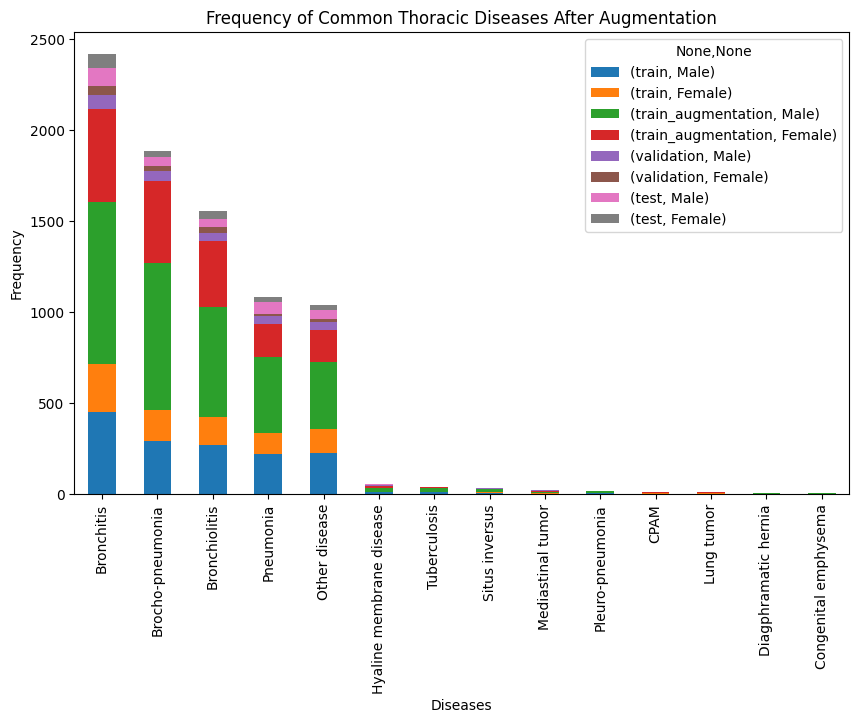

In [ ]:
total_frequency = condition_frequency.sum(axis=1)
sorted_condition_frequency = condition_frequency.loc[total_frequency.sort_values(ascending=False).index]

sorted_condition_frequency.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Diseases')
plt.ylabel('Frequency')
plt.title('Frequency of Common Thoracic Diseases After Augmentation')
plt.show()

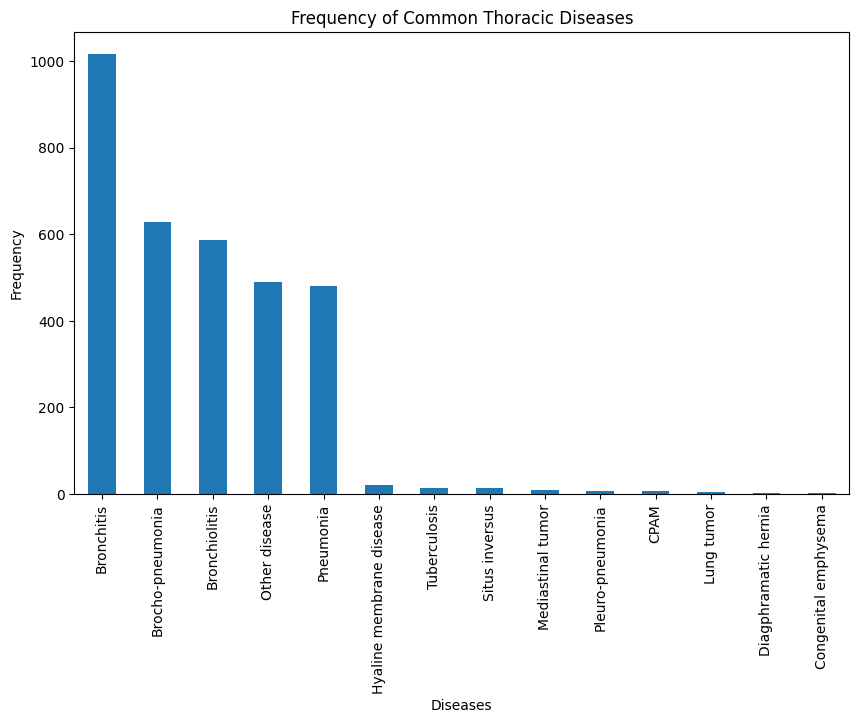

In [ ]:
diseases = ['Bronchitis', 'Brocho-pneumonia', 'Other disease',
                  'Bronchiolitis', 'Situs inversus', 'Pneumonia', 'Pleuro-pneumonia',
                  'Diagphramatic hernia', 'Tuberculosis', 'Congenital emphysema',
                  'CPAM', 'Hyaline membrane disease', 'Mediastinal tumor',
                  'Lung tumor']
before_augmentation = df_descriptive[(df_descriptive['TVT'] == 'train') | (df_descriptive['TVT'] == 'test') |(df_descriptive['TVT'] == 'validation') ]
condition_counts = before_augmentation[diseases].sum().sort_values(ascending=False)

plt.figure(figsize=(10,6))
condition_counts.plot(kind='bar')
plt.title('Frequency of Common Thoracic Diseases')
plt.xlabel('Diseases')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

# YOLOv8 Large - On Colaboratory

In [ ]:
%cd /content/data
!wget 'https://github.com/ultralytics/assets/releases/download/v8.1.0/yolov8l.pt'

In [ ]:
# Settings and loading the YOLOv8 Large model
settings.update({'runs_dir': '/content/drive/MyDrive/DI504 Term Project/runs'})
model_yolo = YOLO('yolov8l.yaml')
model_yolo = YOLO('/content/data/yolov8l.pt')


                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  3    279808  ultralytics.nn.modules.block.C2f             [128, 128, 3, True]           
  3                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  4                  -1  6   2101248  ultralytics.nn.modules.block.C2f             [256, 256, 6, True]           
  5                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256, 512, 3, 2]              
  6                  -1  6   8396800  ultralytics.nn.modules.block.C2f             [512, 512, 6, True]           
  7                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512

In [ ]:
results_yolo = model_yolo.train(data='/content/data/dataset.yaml', task='detect', mode='train',
                      epochs=50, imgsz=640, batch=-1, seed=seed, val=True, plots=True,
                      project='/content/drive/MyDrive/DI504 Term Project/YOLOv8_Model',
                      name='YOLOv8x_Detecting_Findings_XRay',
                      exist_ok=True)

Ultralytics YOLOv8.1.2 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=/content/data/yolov8l.pt, data=/content/data/dataset.yaml, epochs=50, time=None, patience=50, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/DI504 Term Project/YOLOv8_Model, name=YOLOv8x_Detecting_Findings_XRay, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=2649614, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, sa

100%|██████████| 6.23M/6.23M [00:00<00:00, 331MB/s]


AMP: checks passed ✅
AutoBatch: Computing optimal batch size for imgsz=640
AutoBatch: CUDA:0 (NVIDIA A100-SXM4-40GB) 39.56G total, 0.38G reserved, 0.36G allocated, 38.82G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    43657596       165.6         1.242         37.16         58.86        (1, 3, 640, 640)                    list
    43657596       331.1         1.766         31.84           100        (2, 3, 640, 640)                    list
    43657596       662.2         2.770         36.64         58.23        (4, 3, 640, 640)                    list
    43657596        1324         5.169            38         63.41        (8, 3, 640, 640)                    list
    43657596        2649         9.865         59.03         77.05       (16, 3, 640, 640)                    list
AutoBatch: Using batch-size 39 for CUDA:0 23.86G/39.56G (60%) ✅


train: Scanning /content/data/labels/train.cache... 6880 images, 4372 backgrounds, 0 corrupt: 100%|██████████| 11252/11252 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/data/labels/val.cache... 702 images, 772 backgrounds, 0 corrupt: 100%|██████████| 1474/1474 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/DI504 Term Project/YOLOv8_Model/YOLOv8x_Detecting_Findings_XRay/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00025, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.000609375), 103 bias(decay=0.0)
50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      24.7G      2.234       4.99      2.081         23        640: 100%|██████████| 289/289 [01:49<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.36it/s]

                   all       1474        784      0.445      0.014    0.00691    0.00198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50        25G      2.091      3.469      1.942         19        640: 100%|██████████| 289/289 [01:48<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.92it/s]

                   all       1474        784    0.00187      0.127    0.00459     0.0018



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      24.9G      2.059      3.347      1.908         32        640: 100%|██████████| 289/289 [01:45<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.82it/s]

                   all       1474        784    0.00185      0.211    0.00877    0.00313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50        25G      2.001       3.23      1.877         36        640: 100%|██████████| 289/289 [01:43<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.78it/s]

                   all       1474        784      0.432     0.0425     0.0147    0.00468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50        25G       1.95      3.159      1.835         34        640: 100%|██████████| 289/289 [01:43<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.78it/s]

                   all       1474        784      0.532     0.0594     0.0405     0.0167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50        25G      1.935      3.071      1.824         24        640: 100%|██████████| 289/289 [01:43<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.77it/s]

                   all       1474        784      0.389     0.0373     0.0189    0.00685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50        25G      1.913      3.025      1.806         20        640: 100%|██████████| 289/289 [01:42<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.86it/s]

                   all       1474        784      0.426     0.0562      0.018    0.00759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50        25G      1.885      2.988      1.777         25        640: 100%|██████████| 289/289 [01:43<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.72it/s]

                   all       1474        784      0.392     0.0467     0.0231     0.0103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50        25G      1.851      2.948      1.756         25        640: 100%|██████████| 289/289 [01:43<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.71it/s]

                   all       1474        784      0.374     0.0548     0.0328    0.00943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50        25G      1.836      2.912      1.755         22        640: 100%|██████████| 289/289 [01:43<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.78it/s]

                   all       1474        784      0.479     0.0509     0.0212    0.00953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50        25G      1.802      2.838      1.722         41        640: 100%|██████████| 289/289 [01:43<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.84it/s]

                   all       1474        784      0.504     0.0541     0.0312      0.012



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      24.9G      1.776      2.806      1.701         35        640: 100%|██████████| 289/289 [01:43<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.85it/s]

                   all       1474        784      0.347      0.055      0.021    0.00793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50        25G      1.751      2.757      1.683         38        640: 100%|██████████| 289/289 [01:43<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.82it/s]

                   all       1474        784      0.387     0.0619     0.0297     0.0143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50        25G      1.739       2.72      1.685         27        640: 100%|██████████| 289/289 [01:43<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.78it/s]

                   all       1474        784      0.342     0.0442     0.0207    0.00867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50        25G      1.703      2.645      1.644         38        640: 100%|██████████| 289/289 [01:43<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.86it/s]

                   all       1474        784      0.381      0.075      0.024    0.00963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50        25G      1.689       2.62      1.645         23        640: 100%|██████████| 289/289 [01:43<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.92it/s]

                   all       1474        784      0.354     0.0857     0.0286     0.0117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50        25G      1.659      2.558      1.621         28        640: 100%|██████████| 289/289 [01:43<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.78it/s]

                   all       1474        784      0.268     0.0689     0.0262     0.0122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      24.9G      1.613      2.478      1.593         23        640: 100%|██████████| 289/289 [01:43<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.80it/s]

                   all       1474        784      0.315      0.123     0.0293     0.0127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50        25G      1.602      2.424      1.583         30        640: 100%|██████████| 289/289 [01:43<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.88it/s]

                   all       1474        784       0.24      0.078     0.0248     0.0115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50        25G      1.576      2.365      1.567         39        640: 100%|██████████| 289/289 [01:43<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.96it/s]

                   all       1474        784       0.32      0.074     0.0347     0.0144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50        25G      1.539      2.313      1.531         33        640: 100%|██████████| 289/289 [01:43<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.84it/s]

                   all       1474        784       0.18     0.0849     0.0244    0.00812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50        25G      1.503      2.232      1.516         19        640: 100%|██████████| 289/289 [01:43<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.77it/s]

                   all       1474        784      0.186      0.112     0.0237     0.0111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50        25G      1.479       2.18      1.498         24        640: 100%|██████████| 289/289 [01:43<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.87it/s]

                   all       1474        784      0.277     0.0725     0.0298     0.0144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50        25G      1.451      2.106      1.476         23        640: 100%|██████████| 289/289 [01:43<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.93it/s]

                   all       1474        784      0.306     0.0536     0.0244     0.0119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50        25G      1.426      2.039      1.457         27        640: 100%|██████████| 289/289 [01:43<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.81it/s]

                   all       1474        784      0.236     0.0962     0.0269     0.0107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50        25G      1.389      1.968      1.427         25        640: 100%|██████████| 289/289 [01:43<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.84it/s]

                   all       1474        784      0.155      0.075     0.0334     0.0129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50        25G      1.365      1.926      1.414         29        640: 100%|██████████| 289/289 [01:43<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.94it/s]

                   all       1474        784      0.149     0.0539     0.0232    0.00997



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50        25G      1.328      1.847      1.388         30        640: 100%|██████████| 289/289 [01:42<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.93it/s]

                   all       1474        784      0.263     0.0929     0.0344     0.0124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50        25G      1.313      1.809      1.372         29        640: 100%|██████████| 289/289 [01:43<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.82it/s]

                   all       1474        784      0.196     0.0818     0.0342     0.0171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50        25G      1.274      1.739      1.348         26        640: 100%|██████████| 289/289 [01:43<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.88it/s]

                   all       1474        784      0.194     0.0905     0.0347     0.0138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50        25G      1.252      1.686      1.334         38        640: 100%|██████████| 289/289 [01:43<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.97it/s]

                   all       1474        784      0.275     0.0699     0.0223    0.00886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50        25G      1.228      1.622      1.327         29        640: 100%|██████████| 289/289 [01:43<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.88it/s]

                   all       1474        784      0.149     0.0804     0.0268    0.00998



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50        25G        1.2      1.576      1.304         22        640: 100%|██████████| 289/289 [01:43<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.80it/s]

                   all       1474        784      0.166     0.0592      0.029     0.0126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      24.9G      1.175      1.541       1.29         35        640: 100%|██████████| 289/289 [01:43<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.92it/s]

                   all       1474        784      0.147     0.0626       0.02     0.0086



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50        25G      1.158      1.495      1.276         23        640: 100%|██████████| 289/289 [01:42<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.93it/s]

                   all       1474        784      0.153      0.083     0.0218    0.00985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      24.9G      1.123      1.433      1.252         22        640: 100%|██████████| 289/289 [01:43<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.94it/s]

                   all       1474        784      0.229      0.068     0.0182    0.00837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50        25G      1.096      1.402      1.236         21        640: 100%|██████████| 289/289 [01:43<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.84it/s]

                   all       1474        784      0.149     0.0523     0.0176    0.00756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      24.9G      1.079      1.353       1.22         23        640: 100%|██████████| 289/289 [01:43<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.81it/s]

                   all       1474        784      0.103     0.0405     0.0239     0.0094



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50        25G      1.061      1.329      1.214         32        640: 100%|██████████| 289/289 [01:43<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.94it/s]

                   all       1474        784       0.15     0.0473     0.0215     0.0106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      24.9G      1.042      1.288      1.198         16        640: 100%|██████████| 289/289 [01:43<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  3.00it/s]

                   all       1474        784      0.269     0.0389     0.0163    0.00796


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50        25G     0.9818      1.132      1.238         16        640: 100%|██████████| 289/289 [01:45<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.92it/s]

                   all       1474        784      0.188     0.0608     0.0298     0.0141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50        25G     0.9381      1.062        1.2         18        640: 100%|██████████| 289/289 [01:43<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.85it/s]

                   all       1474        784      0.159     0.0686      0.026    0.00946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50        25G     0.9065      1.023      1.182         13        640: 100%|██████████| 289/289 [01:42<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.86it/s]

                   all       1474        784       0.15     0.0913     0.0279     0.0102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50        25G     0.8784     0.9831      1.161         18        640: 100%|██████████| 289/289 [01:43<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.99it/s]

                   all       1474        784     0.0123      0.227     0.0228    0.00965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50        25G      0.861      0.954      1.148         19        640: 100%|██████████| 289/289 [01:42<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.93it/s]

                   all       1474        784       0.18     0.0384     0.0179    0.00796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      24.9G     0.8245     0.9239      1.127         19        640: 100%|██████████| 289/289 [01:42<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.85it/s]

                   all       1474        784     0.0688      0.128      0.025      0.011



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50        25G     0.7993     0.8878      1.099         17        640: 100%|██████████| 289/289 [01:43<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.96it/s]

                   all       1474        784      0.055      0.151     0.0156    0.00708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      24.9G      0.781     0.8649      1.092         15        640: 100%|██████████| 289/289 [01:42<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.97it/s]

                   all       1474        784     0.0127      0.201       0.02    0.00792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50        25G     0.7602     0.8531      1.079         23        640: 100%|██████████| 289/289 [01:43<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.81it/s]

                   all       1474        784      0.108     0.0687     0.0283     0.0147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50        25G     0.7429     0.8265      1.071         22        640: 100%|██████████| 289/289 [01:42<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.85it/s]

                   all       1474        784     0.0111      0.166     0.0185    0.00913



50 epochs completed in 1.561 hours.
Optimizer stripped from /content/drive/MyDrive/DI504 Term Project/YOLOv8_Model/YOLOv8x_Detecting_Findings_XRay/weights/last.pt, 87.7MB
Optimizer stripped from /content/drive/MyDrive/DI504 Term Project/YOLOv8_Model/YOLOv8x_Detecting_Findings_XRay/weights/best.pt, 87.7MB

Validating /content/drive/MyDrive/DI504 Term Project/YOLOv8_Model/YOLOv8x_Detecting_Findings_XRay/weights/best.pt...
Ultralytics YOLOv8.1.2 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 268 layers, 43634364 parameters, 0 gradients, 165.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.34it/s]


                   all       1474        784      0.532     0.0594     0.0404     0.0167
     Boot-shaped heart       1474          3          1          0    0.00582    0.00352
Peribronchovascular interstitial opacity       1474        318     0.0565      0.349      0.043     0.0162
Reticulonodular opacity       1474        132     0.0526      0.205     0.0502     0.0222
  Bronchial thickening       1474        124          1          0     0.0044    0.00106
           Enlarged PA       1474         13          1          0    0.00291   0.000831
          Cardiomegaly       1474         26      0.035      0.538     0.0865     0.0394
         Other opacity       1474         33      0.112     0.0606     0.0397      0.018
Intrathoracic digestive structure       1474         28          1          0     0.0343     0.0125
Diffuse aveolar opacity       1474         12          1          0     0.0017   0.000728
          Other lesion       1474         31          0          0     0.0149  

In [ ]:
yolo_val_source = '/content/data/images/test/*.jpg'
model_yolo = YOLO('/content/drive/MyDrive/DI504 Term Project/YOLOv8_Model/YOLOv8x_Detecting_Findings_XRay/weights/best.pt')
pred_results = model_yolo.predict(source=yolo_val_source, save=True, imgsz=640)



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/1474 /content/data/images/val/000f60ed28579e82c402b99fcff67ef5.jpg: 640x512 (no detections), 184.4ms
image 2/1474 /content/data/images/val/001c350dcc2ecc107afb19512f33b927.jpg: 640x512 (no detections), 19.5ms
image 3/1474 /content/data/images/val/00b818c3d77ae34a189558fdfc798006.jpg: 640x512 (no detections), 19.5ms
image 4/1474 /content/data/images/val/00d28640650ee0561cfff1fcdc99bafd.jpg: 640x512 (no detections), 19.6ms
image 5/1474 /content/d

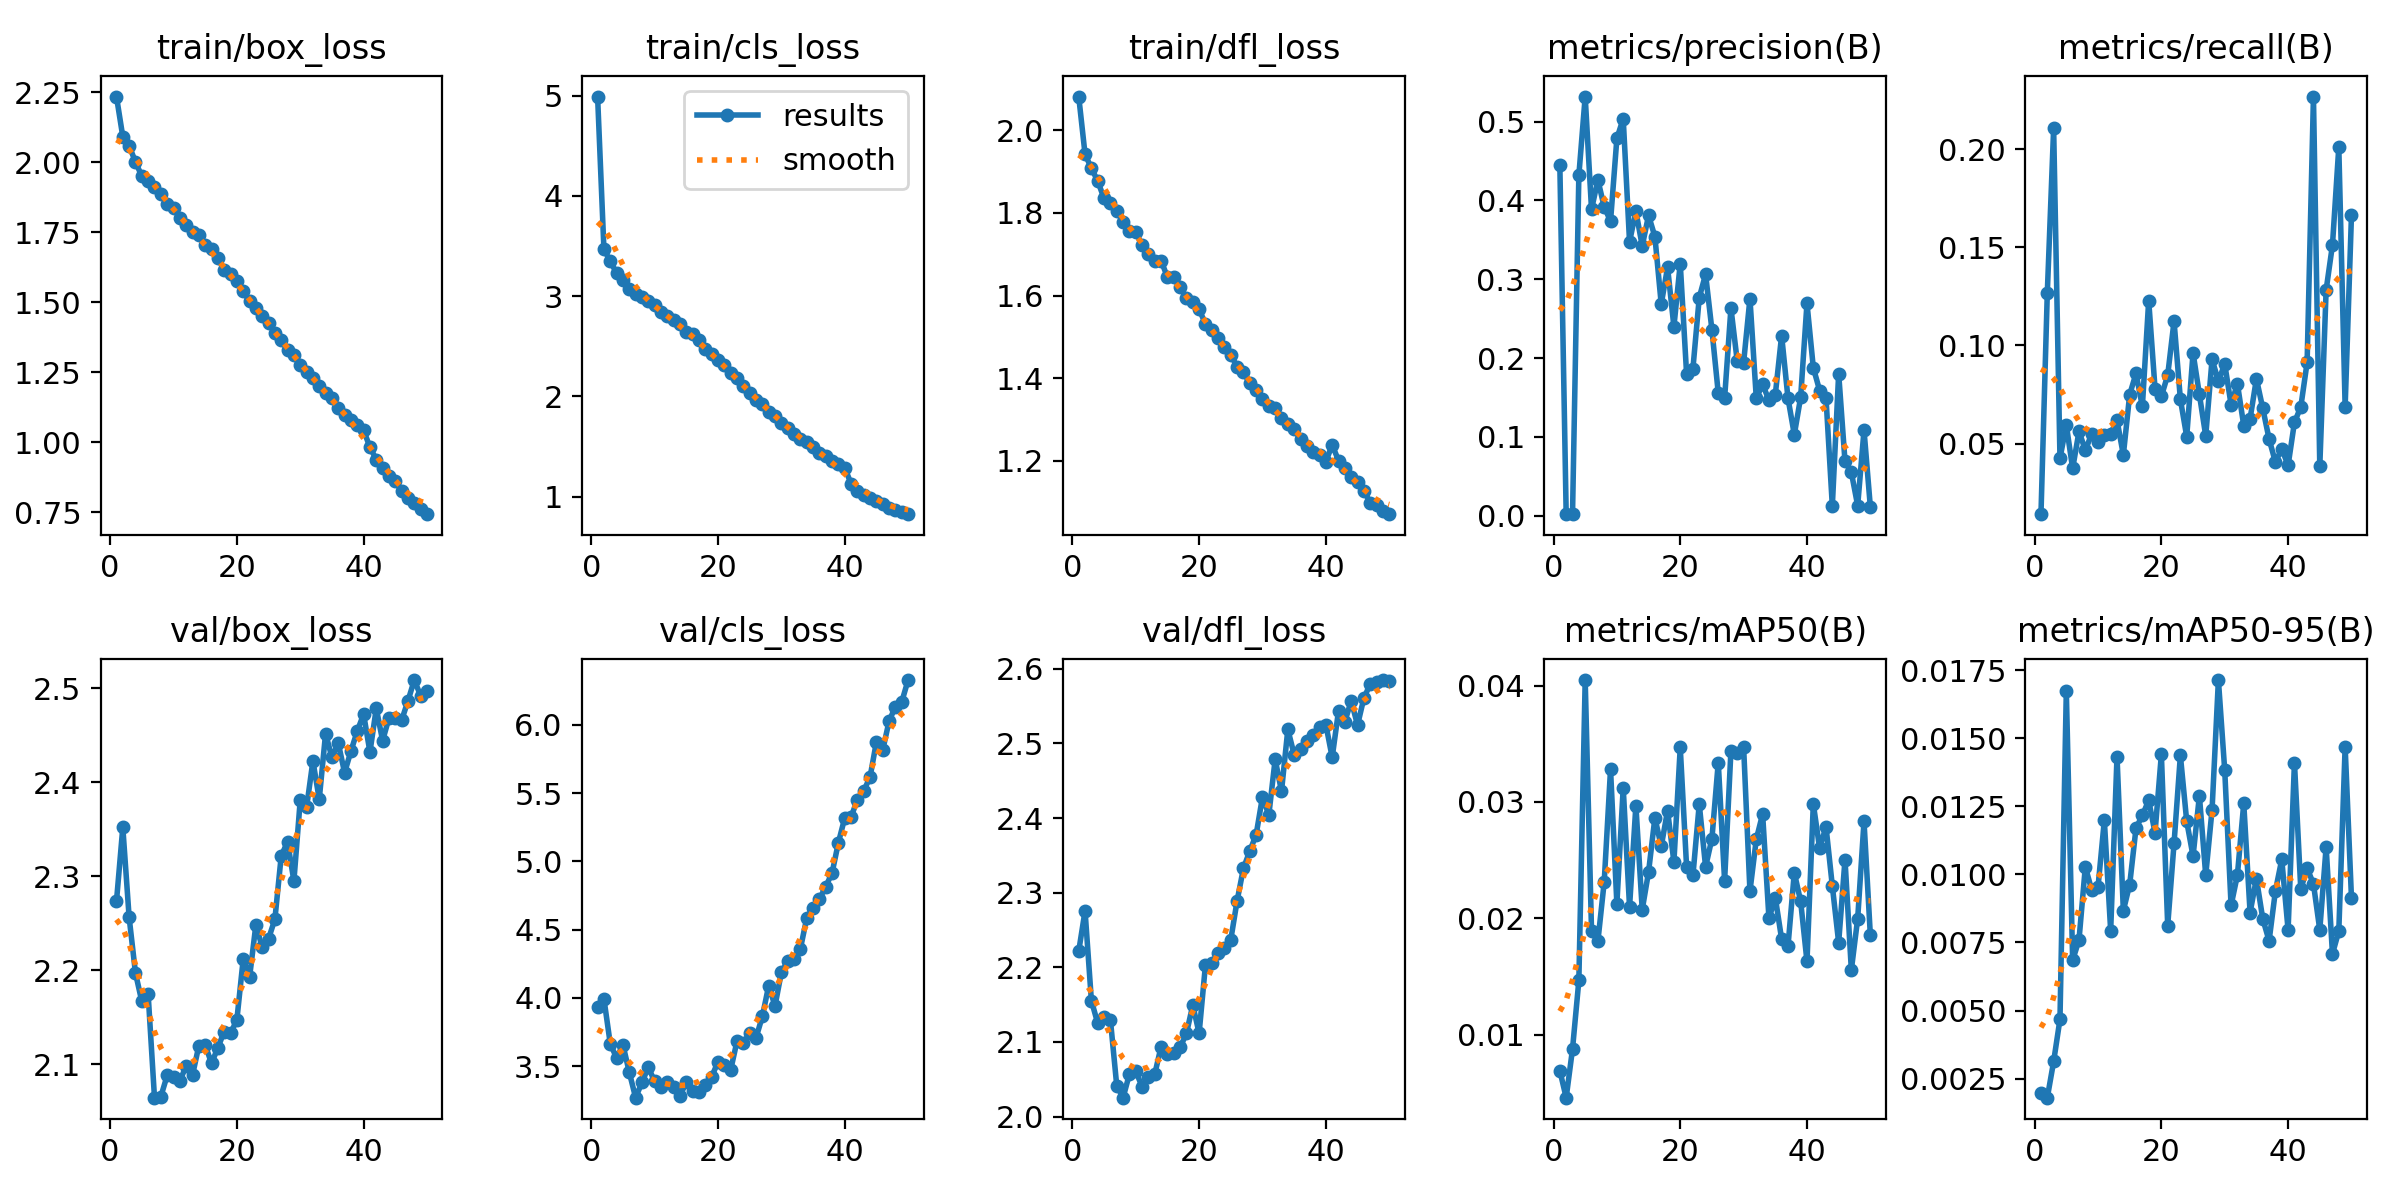

# ResNet -18 (Modified) - On Colaboratory

In [ ]:
# Moving all *.jpg files to /content/data/images_resnet because the data folder format is for YOLO
!mkdir -p /content/data/images_resnet
!cp /content/data/images/train/*.jpg /content/data/images_resnet/
!cp /content/data/images/test/*.jpg /content/data/images_resnet/
!cp /content/data/images/val/*.jpg /content/data/images_resnet/

In [ ]:
main_df = pd.read_csv('/content/data/main_df_augmented.csv').iloc[:,1:]
main_df = main_df.drop_duplicates(subset='image_id', keep='first')
main_df.head()

,image_id,rad_ID,class_name,x_min,y_min,x_max,y_max,class_id,image_path,image_width,...,Congenital emphysema,CPAM,Hyaline membrane disease,Mediastinal tumor,Lung tumor,TVT,YOLO_class_name,age_in_days,normalized_age,normalized_sex
0,03d56a9709a81b2e9d6afbc6647c8730,R3,Boot-shaped heart,378.760010,401.416645,835.143248,661.678438,0,train/03d56a9709a81b2e9d6afbc6647c8730.dicom,1073,...,0.0,0.0,0.0,0.0,0.0,train,0.0,90.0,0.004835,0
1,48f7ba0b0fd5ab847ee87df2aed5cfc9,R3,Peribronchovascular interstitial opacity,247.196368,412.000819,441.763442,830.320028,1,train/48f7ba0b0fd5ab847ee87df2aed5cfc9.dicom,1177,...,0.0,0.0,0.0,0.0,0.0,train,1.0,365.0,0.019608,1
3,74f8648d742bbcce79d67c967de5552d,R3,Peribronchovascular interstitial opacity,1008.515903,665.439667,1324.430364,1265.465119,1,train/74f8648d742bbcce79d67c967de5552d.dicom,1692,...,0.0,0.0,0.0,0.0,0.0,train,1.0,1095.0,0.058824,0
5,e30f04846ebdf6d40eb99757f82c5a89,R3,Peribronchovascular interstitial opacity,671.865876,329.501798,847.363825,658.212242,1,train/e30f04846ebdf6d40eb99757f82c5a89.dicom,1077,...,0.0,0.0,0.0,0.0,0.0,train,1.0,18.0,0.000967,0
7,86ebb0c1c68ea9c4ae596a3d87833862,R3,Reticulonodular opacity,748.622608,430.932036,1024.730349,1022.838004,2,train/86ebb0c1c68ea9c4ae596a3d87833862.dicom,1267,...,0.0,0.0,0.0,0.0,0.0,train,2.0,365.0,0.019608,1


In [ ]:
train_df = main_df[(main_df['TVT'] == 'train_augmentation') | (main_df['TVT'] == 'train' )]
val_df = main_df[main_df['TVT'] == 'validation']
test_df = main_df[main_df['TVT'] == 'test']

> Calculating Mean and Std to Transform Normalize The Images

In [ ]:
# @title
# class XRayDatasetWithoutNormalization(Dataset):
#   def __init__(self, dataframe, transform=None):
#       self.dataframe = dataframe
#       if transform is None:
#           self.transform = transforms.Compose([
#               transforms.Resize((224, 224)),
#               transforms.Grayscale(num_output_channels=3),  # Converts to 3-channel grayscale
#               transforms.ToTensor(),
#           ])
#       else:
#           self.transform = transform

#   def __len__(self):
#     return len(self.dataframe)

#   def __getitem__(self, idx):
#     try:
#       row = self.dataframe.iloc[idx]
#       # Load image in grayscale
#       image_path = os.path.join('/content/data/images_resnet', row['image_id'] + '.jpg')
#       image = Image.open(image_path).convert('L')
#       if self.transform:
#           image = self.transform(image)
#     except Exception as e:
#       print(f"Error in loading data at index {idx}: {e}")
#       raise

#     # Additional features
#     age = row['normalized_age']
#     sex = row['normalized_sex']
#     features = torch.tensor([age, sex], dtype=torch.float32)

#     # One-hot encoded labels
#     labels = row[['No finding', 'Bronchitis', 'Brocho-pneumonia', 'Other disease',
#                   'Bronchiolitis', 'Situs inversus', 'Pneumonia', 'Pleuro-pneumonia',
#                   'Diagphramatic hernia', 'Tuberculosis', 'Congenital emphysema',
#                   'CPAM', 'Hyaline membrane disease', 'Mediastinal tumor',
#                   'Lung tumor']].values.astype(np.float32)  # Convert to float32
#     labels = torch.tensor(labels, dtype=torch.float32)

#     return image, features, labels

# def calculate_mean_std(loader):
#     channels_sum, channels_squared_sum, num_batches = 0, 0, 0

#     for data, _, _ in loader:
#         channels_sum += torch.mean(data, dim=[0, 2, 3])
#         channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
#         num_batches += 1

#     mean = channels_sum / num_batches
#     std = (channels_squared_sum / num_batches - mean**2)**0.5
#     return mean, std

# train_dataset = XRayDatasetWithoutNormalization(train_df)

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=2)
# mean, std = calculate_mean_std(train_loader)

# print(f"Mean: {mean}")
# print(f"Std: {std}")

Mean: tensor([0.4222, 0.4222, 0.4222])
Std: tensor([0.1972, 0.1972, 0.1972])


In [ ]:
class XRayDataset(Dataset):
  def __init__(self, dataframe, transform=None):
      self.dataframe = dataframe
      if transform is None:
          self.transform = transforms.Compose([
              transforms.Resize((224, 224)),
              transforms.Grayscale(num_output_channels=3),  # Converts to 3-channel grayscale
              transforms.ToTensor(),
              transforms.Normalize(mean=[0.4222], std=[0.1972])  # Adjusted for grayscale
          ])
      else:
          self.transform = transform

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, idx):
    try:
      row = self.dataframe.iloc[idx]
      # Load image in grayscale
      image_path = os.path.join('/content/data/images_resnet', row['image_id'] + '.jpg')
      image = Image.open(image_path).convert('L')
      if self.transform:
          image = self.transform(image)
    except Exception as e:
      print(f"Error in loading data at index {idx}: {e}")
      raise

    # Additional features
    age = row['normalized_age']
    sex = row['normalized_sex']
    features = torch.tensor([age, sex], dtype=torch.float32)

    # One-hot encoded labels
    labels = row[['No finding', 'Bronchitis', 'Brocho-pneumonia', 'Other disease',
                  'Bronchiolitis', 'Situs inversus', 'Pneumonia', 'Pleuro-pneumonia',
                  'Diagphramatic hernia', 'Tuberculosis', 'Congenital emphysema',
                  'CPAM', 'Hyaline membrane disease', 'Mediastinal tumor',
                  'Lung tumor']].values.astype(np.float32)
    labels = torch.tensor(labels, dtype=torch.float32)

    return image, features, labels


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ResNetWithFeatures(nn.Module):
    def __init__(self, num_classes, num_features):
        super(ResNetWithFeatures, self).__init__()

        # Load a pretrained ResNet model
        self.resnet = models.resnet18(weights='ResNet18_Weights.DEFAULT')

        # Modify the fully connected layer to accommodate additional features
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()  # Remove the fully connected layer to combine additional features

        # Define a new fully connected layer that takes both image features and additional features
        self.fc = nn.Linear(num_ftrs + num_features, num_classes)

    def forward(self, image, features):
        # Pass the image through the ResNet model
        image_features = self.resnet(image)

        # Concatenate image features with additional features
        combined_features = torch.cat((image_features, features), dim=1)

        # Pass the combined features through the new fully connected layer
        x = self.fc(combined_features)
        return x

# Initialize the model
model = ResNetWithFeatures(num_classes=15, num_features=2)  # 15 diseases, 2 additional features

# Create dataset objects
train_dataset = XRayDataset(train_df)
val_dataset = XRayDataset(val_df)
test_dataset = XRayDataset(test_df)

# Create data loaders
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Weighted BCE Loss Function's Weights
class_counts = train_df[['No finding', 'Bronchitis', 'Brocho-pneumonia', 'Other disease',
                        'Bronchiolitis', 'Situs inversus', 'Pneumonia', 'Pleuro-pneumonia',
                        'Diagphramatic hernia', 'Tuberculosis', 'Congenital emphysema',
                        'CPAM', 'Hyaline membrane disease', 'Mediastinal tumor',
                        'Lung tumor']].sum().to_numpy()
total_samples = len(train_df)
class_weights = total_samples / (15 * class_counts)  # 15 is the number of classes
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)


In [ ]:
# Train Loop
def train_model(trial):

  model = ResNetWithFeatures(num_classes=15, num_features=2)
  model.to(device)

  # Define loss function
  criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)

  # Define optimizer with trial-suggested parameters
  lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
  optimizer = optim.AdamW(model.parameters(), lr=lr)

  metrics = {'train_loss': [], 'val_loss': [], 'precision': [], 'recall': [], 'f1': [], 'avg_auc_roc': []}
  avg_val_loss = None


  num_epochs = 30
  best_val_f1 = 0
  patience = 4  # Number of epochs to wait for improvement before stopping
  epochs_without_improvement = 0

  for epoch in range(num_epochs):
    print(f"Starting Epoch {epoch + 1}")

    # Training phase
    model.train()
    running_loss = 0.0
    train_progress_bar = tqdm(train_loader, desc="Training", unit="batch")
    for images, features, labels in train_progress_bar:
        images, features, labels = images.to(device), features.to(device), labels.to(device)

        # Forward pass
        outputs = model(images, features)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0.0
    all_outputs = []
    all_labels = []
    num_batches = 0  # Initialize num_batches
    val_progress_bar = tqdm(val_loader, desc="Validation", unit="batch")
    with torch.no_grad():
        for images, features, labels in val_progress_bar:
            images, features, labels = images.to(device), features.to(device), labels.to(device)
            outputs = model(images, features)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            num_batches += 1  # Increment num_batches for each batch

            # Collect outputs and labels for precision calculation
            all_outputs.append(outputs.cpu())
            all_labels.append(labels.cpu())


    # Calculate average losses
    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / num_batches if num_batches > 0 else 0

    # Calculate precision
    all_outputs = torch.cat(all_outputs).sigmoid().numpy() > 0.5  # Apply threshold
    all_labels = torch.cat(all_labels).numpy()
    precision = precision_score(all_labels, all_outputs, average='macro', zero_division=1)
    recall = recall_score(all_labels, all_outputs, average='macro', zero_division=1)
    f1 = f1_score(all_labels, all_outputs, average='macro', zero_division=1)

    # Calculate average AUC-ROC for each label
    auc_roc_scores = []
    for i in range(all_labels.shape[1]):
        if len(np.unique(all_labels[:, i])) > 1:
            auc_roc = roc_auc_score(all_labels[:, i], all_outputs[:, i])
            auc_roc_scores.append(auc_roc)
        else:
            auc_roc_scores.append(np.nan)  # Handle class absence in validation set

    avg_auc_roc = np.nanmean(auc_roc_scores)  # Compute the average AUC-ROC

    metrics['train_loss'].append(avg_train_loss)
    metrics['val_loss'].append(avg_val_loss)
    metrics['precision'].append(precision)
    metrics['recall'].append(recall)
    metrics['f1'].append(f1)
    metrics['avg_auc_roc'].append(avg_auc_roc)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score(Macro): {f1:.4f}, Average AUC-ROC: {avg_auc_roc:.4f}")

    # Check for improvement
    if f1 > best_val_f1:  # Replace f1 with avg_val_loss if minimizing loss
        best_val_f1 = f1
        epochs_without_improvement = 0
        # Save the model if it's the best so far
        model_save_path = f'/content/drive/MyDrive/DI504 Term Project/ResNet/model_trial_{trial.number}.pth'
        torch.save(model.state_dict(), model_save_path)
    else:
        epochs_without_improvement += 1

    # Break the training loop if the patience is exceeded
    if epochs_without_improvement >= patience:
        print(f"No improvement for {patience} consecutive epochs, stopping training.")
        break

  # Save metrics to a JSON file
  with open(f'/content/drive/MyDrive/DI504 Term Project/ResNet/model_metrics_{trial.number}.json', 'w') as f:
      json.dump(metrics, f)

  print(f'Training {trial.number}.  iteration finish!\n\n')
  return best_val_f1

def objective(trial):
    return train_model(trial)


In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print("Best trial:")
best_trial = study.best_trial
print(" Value: ", best_trial.value)
print(" Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))


Starting Epoch 1


Validation: 100%|██████████| 5/5 [00:22<00:00,  4.52s/batch]


Epoch [1/30] - Train Loss: 0.4655, Val Loss: 0.2876, Precision: 0.6356, Recall: 0.1817, F1-Score(Macro): 0.1112, Average AUC-ROC: 0.5272
Starting Epoch 2


Validation: 100%|██████████| 5/5 [00:22<00:00,  4.51s/batch]


Epoch [2/30] - Train Loss: 0.2180, Val Loss: 0.1932, Precision: 0.9048, Recall: 0.2204, F1-Score(Macro): 0.2231, Average AUC-ROC: 0.5501
Starting Epoch 3


Validation: 100%|██████████| 5/5 [00:20<00:00,  4.17s/batch]


Epoch [3/30] - Train Loss: 0.1470, Val Loss: 0.1638, Precision: 0.8533, Recall: 0.2202, F1-Score(Macro): 0.2315, Average AUC-ROC: 0.5500
Starting Epoch 4


Validation: 100%|██████████| 5/5 [00:14<00:00,  2.98s/batch]


Epoch [4/30] - Train Loss: 0.1186, Val Loss: 0.1563, Precision: 0.9122, Recall: 0.1906, F1-Score(Macro): 0.1940, Average AUC-ROC: 0.5322
Starting Epoch 5


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.11s/batch]


Epoch [5/30] - Train Loss: 0.1034, Val Loss: 0.1527, Precision: 0.9130, Recall: 0.1969, F1-Score(Macro): 0.2042, Average AUC-ROC: 0.5351
Starting Epoch 6


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.30s/batch]


Epoch [6/30] - Train Loss: 0.0923, Val Loss: 0.1502, Precision: 0.9405, Recall: 0.1783, F1-Score(Macro): 0.2011, Average AUC-ROC: 0.5239
Starting Epoch 7


Validation: 100%|██████████| 5/5 [00:14<00:00,  2.93s/batch]


Epoch [7/30] - Train Loss: 0.0868, Val Loss: 0.1500, Precision: 0.9490, Recall: 0.1805, F1-Score(Macro): 0.2039, Average AUC-ROC: 0.5249
No improvement for 4 consecutive epochs, stopping training.
Training 0.  iteration finish!


Starting Epoch 1


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.09s/batch]


Epoch [1/30] - Train Loss: 0.5746, Val Loss: 0.5170, Precision: 0.2572, Recall: 0.4906, F1-Score(Macro): 0.0973, Average AUC-ROC: 0.6001
Starting Epoch 2


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.12s/batch]


Epoch [2/30] - Train Loss: 0.4354, Val Loss: 0.3783, Precision: 0.4012, Recall: 0.2908, F1-Score(Macro): 0.1220, Average AUC-ROC: 0.5641
Starting Epoch 3


Validation: 100%|██████████| 5/5 [00:18<00:00,  3.72s/batch]


Epoch [3/30] - Train Loss: 0.3425, Val Loss: 0.3107, Precision: 0.6949, Recall: 0.2673, F1-Score(Macro): 0.2186, Average AUC-ROC: 0.5685
Starting Epoch 4


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.11s/batch]


Epoch [4/30] - Train Loss: 0.2780, Val Loss: 0.2746, Precision: 0.8003, Recall: 0.2475, F1-Score(Macro): 0.2384, Average AUC-ROC: 0.5644
Starting Epoch 5


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.09s/batch]


Epoch [5/30] - Train Loss: 0.2311, Val Loss: 0.2283, Precision: 0.8472, Recall: 0.2447, F1-Score(Macro): 0.2386, Average AUC-ROC: 0.5637
Starting Epoch 6


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.24s/batch]


Epoch [6/30] - Train Loss: 0.2008, Val Loss: 0.2018, Precision: 0.8378, Recall: 0.2564, F1-Score(Macro): 0.2436, Average AUC-ROC: 0.5703
Starting Epoch 7


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.17s/batch]


Epoch [7/30] - Train Loss: 0.1755, Val Loss: 0.1844, Precision: 0.8381, Recall: 0.2563, F1-Score(Macro): 0.2335, Average AUC-ROC: 0.5703
Starting Epoch 8


Validation: 100%|██████████| 5/5 [00:14<00:00,  2.97s/batch]


Epoch [8/30] - Train Loss: 0.1584, Val Loss: 0.1763, Precision: 0.8336, Recall: 0.2554, F1-Score(Macro): 0.2420, Average AUC-ROC: 0.5699
Starting Epoch 9


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.10s/batch]


Epoch [9/30] - Train Loss: 0.1468, Val Loss: 0.1664, Precision: 0.8233, Recall: 0.2550, F1-Score(Macro): 0.2413, Average AUC-ROC: 0.5695
Starting Epoch 10


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.15s/batch]


Epoch [10/30] - Train Loss: 0.1344, Val Loss: 0.1597, Precision: 0.8147, Recall: 0.2551, F1-Score(Macro): 0.2332, Average AUC-ROC: 0.5695
No improvement for 4 consecutive epochs, stopping training.
Training 1.  iteration finish!


Starting Epoch 1


Validation: 100%|██████████| 5/5 [00:18<00:00,  3.64s/batch]


Epoch [1/30] - Train Loss: 0.5681, Val Loss: 0.4092, Precision: 0.2888, Recall: 0.3107, F1-Score(Macro): 0.0842, Average AUC-ROC: 0.5444
Starting Epoch 2


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.11s/batch]


Epoch [2/30] - Train Loss: 0.2860, Val Loss: 0.2332, Precision: 0.8486, Recall: 0.2070, F1-Score(Macro): 0.2007, Average AUC-ROC: 0.5422
Starting Epoch 3


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.12s/batch]


Epoch [3/30] - Train Loss: 0.1946, Val Loss: 0.1901, Precision: 0.8889, Recall: 0.2203, F1-Score(Macro): 0.2097, Average AUC-ROC: 0.5497
Starting Epoch 4


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.17s/batch]


Epoch [4/30] - Train Loss: 0.1528, Val Loss: 0.1729, Precision: 0.8205, Recall: 0.2203, F1-Score(Macro): 0.2081, Average AUC-ROC: 0.5497
Starting Epoch 5


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.06s/batch]


Epoch [5/30] - Train Loss: 0.1400, Val Loss: 0.1636, Precision: 0.8267, Recall: 0.2213, F1-Score(Macro): 0.2159, Average AUC-ROC: 0.5504
Starting Epoch 6


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.25s/batch]


Epoch [6/30] - Train Loss: 0.1245, Val Loss: 0.1599, Precision: 0.8351, Recall: 0.2099, F1-Score(Macro): 0.2240, Average AUC-ROC: 0.5437
Starting Epoch 7


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.12s/batch]


Epoch [7/30] - Train Loss: 0.1102, Val Loss: 0.1548, Precision: 0.8462, Recall: 0.2109, F1-Score(Macro): 0.2302, Average AUC-ROC: 0.5442
Starting Epoch 8


Validation: 100%|██████████| 5/5 [00:18<00:00,  3.61s/batch]


Epoch [8/30] - Train Loss: 0.1017, Val Loss: 0.1546, Precision: 0.8418, Recall: 0.1887, F1-Score(Macro): 0.2124, Average AUC-ROC: 0.5311
Starting Epoch 9


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.07s/batch]


Epoch [9/30] - Train Loss: 0.0956, Val Loss: 0.1545, Precision: 0.8539, Recall: 0.1907, F1-Score(Macro): 0.2159, Average AUC-ROC: 0.5323
Starting Epoch 10


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.02s/batch]


Epoch [10/30] - Train Loss: 0.0901, Val Loss: 0.1581, Precision: 0.8509, Recall: 0.1938, F1-Score(Macro): 0.2205, Average AUC-ROC: 0.5337
Starting Epoch 11


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.08s/batch]


Epoch [11/30] - Train Loss: 0.0853, Val Loss: 0.1605, Precision: 0.8871, Recall: 0.1962, F1-Score(Macro): 0.2272, Average AUC-ROC: 0.5349
No improvement for 4 consecutive epochs, stopping training.
Training 2.  iteration finish!


Starting Epoch 1


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.23s/batch]


Epoch [1/30] - Train Loss: 0.3284, Val Loss: 0.1529, Precision: 0.8944, Recall: 0.2067, F1-Score(Macro): 0.1731, Average AUC-ROC: 0.5418
Starting Epoch 2


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.09s/batch]


Epoch [2/30] - Train Loss: 0.1316, Val Loss: 0.1419, Precision: 0.8985, Recall: 0.1837, F1-Score(Macro): 0.2039, Average AUC-ROC: 0.5289
Starting Epoch 3


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.10s/batch]


Epoch [3/30] - Train Loss: 0.0950, Val Loss: 0.1360, Precision: 0.8638, Recall: 0.3335, F1-Score(Macro): 0.3471, Average AUC-ROC: 0.6112
Starting Epoch 4


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.08s/batch]


Epoch [4/30] - Train Loss: 0.0796, Val Loss: 0.1460, Precision: 0.8256, Recall: 0.2838, F1-Score(Macro): 0.3151, Average AUC-ROC: 0.5805
Starting Epoch 5


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.20s/batch]


Epoch [5/30] - Train Loss: 0.0665, Val Loss: 0.1606, Precision: 0.8857, Recall: 0.2658, F1-Score(Macro): 0.3142, Average AUC-ROC: 0.5684
Starting Epoch 6


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.09s/batch]


Epoch [6/30] - Train Loss: 0.0535, Val Loss: 0.1682, Precision: 0.8118, Recall: 0.2958, F1-Score(Macro): 0.3385, Average AUC-ROC: 0.5898
Starting Epoch 7


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.09s/batch]


Epoch [7/30] - Train Loss: 0.0386, Val Loss: 0.2040, Precision: 0.8527, Recall: 0.3478, F1-Score(Macro): 0.4152, Average AUC-ROC: 0.6179
Starting Epoch 8


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.08s/batch]


Epoch [8/30] - Train Loss: 0.0254, Val Loss: 0.1944, Precision: 0.8037, Recall: 0.3254, F1-Score(Macro): 0.3726, Average AUC-ROC: 0.6000
Starting Epoch 9


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.08s/batch]


Epoch [9/30] - Train Loss: 0.0244, Val Loss: 0.1870, Precision: 0.8675, Recall: 0.3330, F1-Score(Macro): 0.3799, Average AUC-ROC: 0.6019
Starting Epoch 10


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.07s/batch]


Epoch [10/30] - Train Loss: 0.0533, Val Loss: 0.1643, Precision: 0.6842, Recall: 0.3587, F1-Score(Macro): 0.3504, Average AUC-ROC: 0.6199
Starting Epoch 11


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.09s/batch]


Epoch [11/30] - Train Loss: 0.0262, Val Loss: 0.1963, Precision: 0.7116, Recall: 0.3362, F1-Score(Macro): 0.3071, Average AUC-ROC: 0.5984
No improvement for 4 consecutive epochs, stopping training.
Training 3.  iteration finish!


Starting Epoch 1


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.11s/batch]


Epoch [1/30] - Train Loss: 0.6383, Val Loss: 0.5332, Precision: 0.2104, Recall: 0.3827, F1-Score(Macro): 0.1553, Average AUC-ROC: 0.5259
Starting Epoch 2


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.09s/batch]


Epoch [2/30] - Train Loss: 0.4665, Val Loss: 0.3967, Precision: 0.4527, Recall: 0.3036, F1-Score(Macro): 0.1634, Average AUC-ROC: 0.5506
Starting Epoch 3


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.11s/batch]


Epoch [3/30] - Train Loss: 0.3401, Val Loss: 0.3027, Precision: 0.6564, Recall: 0.1771, F1-Score(Macro): 0.1954, Average AUC-ROC: 0.5092
Starting Epoch 4


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.14s/batch]


Epoch [4/30] - Train Loss: 0.2680, Val Loss: 0.2493, Precision: 0.7901, Recall: 0.1701, F1-Score(Macro): 0.1843, Average AUC-ROC: 0.5179
Starting Epoch 5


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.13s/batch]


Epoch [5/30] - Train Loss: 0.2212, Val Loss: 0.2191, Precision: 0.8278, Recall: 0.1943, F1-Score(Macro): 0.2093, Average AUC-ROC: 0.5348
Starting Epoch 6


Validation: 100%|██████████| 5/5 [00:19<00:00,  3.83s/batch]


Epoch [6/30] - Train Loss: 0.1916, Val Loss: 0.1932, Precision: 0.8952, Recall: 0.2072, F1-Score(Macro): 0.2121, Average AUC-ROC: 0.5422
Starting Epoch 7


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.20s/batch]


Epoch [7/30] - Train Loss: 0.1694, Val Loss: 0.1791, Precision: 0.8286, Recall: 0.1739, F1-Score(Macro): 0.1677, Average AUC-ROC: 0.5230
Starting Epoch 8


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.27s/batch]


Epoch [8/30] - Train Loss: 0.1574, Val Loss: 0.1707, Precision: 0.8381, Recall: 0.2071, F1-Score(Macro): 0.1823, Average AUC-ROC: 0.5422
Starting Epoch 9


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.10s/batch]


Epoch [9/30] - Train Loss: 0.1436, Val Loss: 0.1653, Precision: 0.8346, Recall: 0.2071, F1-Score(Macro): 0.1778, Average AUC-ROC: 0.5421
Starting Epoch 10


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.13s/batch]


Epoch [10/30] - Train Loss: 0.1324, Val Loss: 0.1616, Precision: 0.8369, Recall: 0.2073, F1-Score(Macro): 0.1812, Average AUC-ROC: 0.5422
No improvement for 4 consecutive epochs, stopping training.
Training 4.  iteration finish!


Starting Epoch 1


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.11s/batch]


Epoch [1/30] - Train Loss: 0.2721, Val Loss: 0.3591, Precision: 0.7923, Recall: 0.2712, F1-Score(Macro): 0.0772, Average AUC-ROC: 0.5507
Starting Epoch 2


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.11s/batch]


Epoch [2/30] - Train Loss: 0.2008, Val Loss: 0.1984, Precision: 0.7415, Recall: 0.1899, F1-Score(Macro): 0.1160, Average AUC-ROC: 0.5294
Starting Epoch 3


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.14s/batch]


Epoch [3/30] - Train Loss: 0.1569, Val Loss: 0.1757, Precision: 0.5528, Recall: 0.1774, F1-Score(Macro): 0.0362, Average AUC-ROC: 0.5246
Starting Epoch 4


Validation: 100%|██████████| 5/5 [00:14<00:00,  2.99s/batch]


Epoch [4/30] - Train Loss: 0.1188, Val Loss: 0.1842, Precision: 0.6250, Recall: 0.2412, F1-Score(Macro): 0.1179, Average AUC-ROC: 0.5612
Starting Epoch 5


Validation: 100%|██████████| 5/5 [00:19<00:00,  3.81s/batch]


Epoch [5/30] - Train Loss: 0.0991, Val Loss: 0.2154, Precision: 0.6943, Recall: 0.2583, F1-Score(Macro): 0.1472, Average AUC-ROC: 0.5681
Starting Epoch 6


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.24s/batch]


Epoch [6/30] - Train Loss: 0.0900, Val Loss: 0.1870, Precision: 0.6788, Recall: 0.2605, F1-Score(Macro): 0.2383, Average AUC-ROC: 0.5721
Starting Epoch 7


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.13s/batch]


Epoch [7/30] - Train Loss: 0.0830, Val Loss: 0.2189, Precision: 0.7662, Recall: 0.2414, F1-Score(Macro): 0.1759, Average AUC-ROC: 0.5614
Starting Epoch 8


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.27s/batch]


Epoch [8/30] - Train Loss: 0.0773, Val Loss: 0.2172, Precision: 0.9378, Recall: 0.2545, F1-Score(Macro): 0.2779, Average AUC-ROC: 0.5655
Starting Epoch 9


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.10s/batch]


Epoch [9/30] - Train Loss: 0.0737, Val Loss: 0.2286, Precision: 0.7494, Recall: 0.2733, F1-Score(Macro): 0.2906, Average AUC-ROC: 0.5780
Starting Epoch 10


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.12s/batch]


Epoch [10/30] - Train Loss: 0.0674, Val Loss: 0.2070, Precision: 0.5964, Recall: 0.2330, F1-Score(Macro): 0.1946, Average AUC-ROC: 0.5519
Starting Epoch 11


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.29s/batch]


Epoch [11/30] - Train Loss: 0.0552, Val Loss: 0.2588, Precision: 0.7345, Recall: 0.2224, F1-Score(Macro): 0.1859, Average AUC-ROC: 0.5342
Starting Epoch 12


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.26s/batch]


Epoch [12/30] - Train Loss: 0.0677, Val Loss: 0.2681, Precision: 0.6188, Recall: 0.2023, F1-Score(Macro): 0.1696, Average AUC-ROC: 0.5353
Starting Epoch 13


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.03s/batch]


Epoch [13/30] - Train Loss: 0.1351, Val Loss: 0.9681, Precision: 0.6245, Recall: 0.1508, F1-Score(Macro): 0.1532, Average AUC-ROC: 0.5042
No improvement for 4 consecutive epochs, stopping training.
Training 5.  iteration finish!


Starting Epoch 1


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.07s/batch]


Epoch [1/30] - Train Loss: 0.2552, Val Loss: 0.3303, Precision: 0.7731, Recall: 0.2235, F1-Score(Macro): 0.2092, Average AUC-ROC: 0.5476
Starting Epoch 2


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.18s/batch]


Epoch [2/30] - Train Loss: 0.1702, Val Loss: 0.1964, Precision: 0.7378, Recall: 0.1877, F1-Score(Macro): 0.0954, Average AUC-ROC: 0.5302
Starting Epoch 3


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.22s/batch]


Epoch [3/30] - Train Loss: 0.1315, Val Loss: 0.1564, Precision: 0.7772, Recall: 0.3586, F1-Score(Macro): 0.3324, Average AUC-ROC: 0.6275
Starting Epoch 4


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.09s/batch]


Epoch [4/30] - Train Loss: 0.1120, Val Loss: 0.1636, Precision: 0.7220, Recall: 0.2339, F1-Score(Macro): 0.1535, Average AUC-ROC: 0.5566
Starting Epoch 5


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.12s/batch]


Epoch [5/30] - Train Loss: 0.0912, Val Loss: 0.1660, Precision: 0.7110, Recall: 0.2045, F1-Score(Macro): 0.2060, Average AUC-ROC: 0.5393
Starting Epoch 6


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.11s/batch]


Epoch [6/30] - Train Loss: 0.0814, Val Loss: 0.1659, Precision: 0.8266, Recall: 0.2811, F1-Score(Macro): 0.2627, Average AUC-ROC: 0.5815
Starting Epoch 7


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.13s/batch]


Epoch [7/30] - Train Loss: 0.0757, Val Loss: 0.2147, Precision: 0.8470, Recall: 0.2379, F1-Score(Macro): 0.2529, Average AUC-ROC: 0.5538
No improvement for 4 consecutive epochs, stopping training.
Training 6.  iteration finish!


Starting Epoch 1


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.27s/batch]


Epoch [1/30] - Train Loss: 0.3488, Val Loss: 0.1612, Precision: 0.8520, Recall: 0.2868, F1-Score(Macro): 0.2096, Average AUC-ROC: 0.5879
Starting Epoch 2


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.00s/batch]


Epoch [2/30] - Train Loss: 0.1402, Val Loss: 0.1612, Precision: 0.7875, Recall: 0.2173, F1-Score(Macro): 0.1686, Average AUC-ROC: 0.5482
Starting Epoch 3


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.15s/batch]


Epoch [3/30] - Train Loss: 0.1105, Val Loss: 0.1727, Precision: 0.8056, Recall: 0.2977, F1-Score(Macro): 0.2934, Average AUC-ROC: 0.5930
Starting Epoch 4


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.06s/batch]


Epoch [4/30] - Train Loss: 0.0888, Val Loss: 0.1555, Precision: 0.8899, Recall: 0.2764, F1-Score(Macro): 0.2936, Average AUC-ROC: 0.5804
Starting Epoch 5


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.09s/batch]


Epoch [5/30] - Train Loss: 0.0791, Val Loss: 0.1820, Precision: 0.8846, Recall: 0.2825, F1-Score(Macro): 0.3077, Average AUC-ROC: 0.5836
Starting Epoch 6


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.10s/batch]


Epoch [6/30] - Train Loss: 0.0709, Val Loss: 0.1650, Precision: 0.8893, Recall: 0.2858, F1-Score(Macro): 0.3234, Average AUC-ROC: 0.5855
Starting Epoch 7


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.20s/batch]


Epoch [7/30] - Train Loss: 0.0744, Val Loss: 0.2251, Precision: 0.9039, Recall: 0.2476, F1-Score(Macro): 0.2684, Average AUC-ROC: 0.5638
Starting Epoch 8


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.22s/batch]


Epoch [8/30] - Train Loss: 0.0841, Val Loss: 0.1557, Precision: 0.5597, Recall: 0.2852, F1-Score(Macro): 0.3008, Average AUC-ROC: 0.5831
Starting Epoch 9


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.07s/batch]


Epoch [9/30] - Train Loss: 0.0634, Val Loss: 0.2223, Precision: 0.7621, Recall: 0.2693, F1-Score(Macro): 0.2962, Average AUC-ROC: 0.5710
Starting Epoch 10


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.13s/batch]


Epoch [10/30] - Train Loss: 0.0510, Val Loss: 0.1843, Precision: 0.8159, Recall: 0.2706, F1-Score(Macro): 0.3060, Average AUC-ROC: 0.5744
No improvement for 4 consecutive epochs, stopping training.
Training 7.  iteration finish!


Starting Epoch 1


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.09s/batch]


Epoch [1/30] - Train Loss: 0.2809, Val Loss: 0.1482, Precision: 0.9151, Recall: 0.2280, F1-Score(Macro): 0.2027, Average AUC-ROC: 0.5543
Starting Epoch 2


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.08s/batch]


Epoch [2/30] - Train Loss: 0.1178, Val Loss: 0.1359, Precision: 0.8762, Recall: 0.2780, F1-Score(Macro): 0.2781, Average AUC-ROC: 0.5823
Starting Epoch 3


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.23s/batch]


Epoch [3/30] - Train Loss: 0.0888, Val Loss: 0.1436, Precision: 0.8808, Recall: 0.2590, F1-Score(Macro): 0.2818, Average AUC-ROC: 0.5704
Starting Epoch 4


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.26s/batch]


Epoch [4/30] - Train Loss: 0.0767, Val Loss: 0.1786, Precision: 0.8793, Recall: 0.2341, F1-Score(Macro): 0.2512, Average AUC-ROC: 0.5569
Starting Epoch 5


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.08s/batch]


Epoch [5/30] - Train Loss: 0.0635, Val Loss: 0.1996, Precision: 0.9156, Recall: 0.2840, F1-Score(Macro): 0.3237, Average AUC-ROC: 0.5829
Starting Epoch 6


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.15s/batch]


Epoch [6/30] - Train Loss: 0.0487, Val Loss: 0.1632, Precision: 0.8279, Recall: 0.2322, F1-Score(Macro): 0.2671, Average AUC-ROC: 0.5480
Starting Epoch 7


Validation: 100%|██████████| 5/5 [00:17<00:00,  3.43s/batch]


Epoch [7/30] - Train Loss: 0.0372, Val Loss: 0.1765, Precision: 0.8230, Recall: 0.2797, F1-Score(Macro): 0.3109, Average AUC-ROC: 0.5756
Starting Epoch 8


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.07s/batch]


Epoch [8/30] - Train Loss: 0.0224, Val Loss: 0.2170, Precision: 0.8281, Recall: 0.2494, F1-Score(Macro): 0.2941, Average AUC-ROC: 0.5561
Starting Epoch 9


Validation: 100%|██████████| 5/5 [00:14<00:00,  2.98s/batch]


Epoch [9/30] - Train Loss: 0.0155, Val Loss: 0.1832, Precision: 0.7882, Recall: 0.2477, F1-Score(Macro): 0.2893, Average AUC-ROC: 0.5564
No improvement for 4 consecutive epochs, stopping training.
Training 8.  iteration finish!


Starting Epoch 1


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.11s/batch]


Epoch [1/30] - Train Loss: 0.3667, Val Loss: 0.1953, Precision: 0.7500, Recall: 0.1467, F1-Score(Macro): 0.1481, Average AUC-ROC: 0.5075
Starting Epoch 2


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.17s/batch]


Epoch [2/30] - Train Loss: 0.1446, Val Loss: 0.1472, Precision: 0.8844, Recall: 0.2220, F1-Score(Macro): 0.2084, Average AUC-ROC: 0.5506
Starting Epoch 3


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.28s/batch]


Epoch [3/30] - Train Loss: 0.1043, Val Loss: 0.1472, Precision: 0.8842, Recall: 0.2817, F1-Score(Macro): 0.2823, Average AUC-ROC: 0.5849
Starting Epoch 4


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.34s/batch]


Epoch [4/30] - Train Loss: 0.0880, Val Loss: 0.1807, Precision: 0.8965, Recall: 0.2789, F1-Score(Macro): 0.2976, Average AUC-ROC: 0.5822
Starting Epoch 5


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.25s/batch]


Epoch [5/30] - Train Loss: 0.0778, Val Loss: 0.1525, Precision: 0.9236, Recall: 0.2676, F1-Score(Macro): 0.3015, Average AUC-ROC: 0.5759
Starting Epoch 6


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.12s/batch]


Epoch [6/30] - Train Loss: 0.0659, Val Loss: 0.1609, Precision: 0.8890, Recall: 0.2715, F1-Score(Macro): 0.2905, Average AUC-ROC: 0.5773
Starting Epoch 7


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.11s/batch]


Epoch [7/30] - Train Loss: 0.0517, Val Loss: 0.1665, Precision: 0.8557, Recall: 0.2159, F1-Score(Macro): 0.2512, Average AUC-ROC: 0.5415
Starting Epoch 8


Validation: 100%|██████████| 5/5 [00:14<00:00,  2.98s/batch]


Epoch [8/30] - Train Loss: 0.0354, Val Loss: 0.1646, Precision: 0.8302, Recall: 0.2710, F1-Score(Macro): 0.2958, Average AUC-ROC: 0.5676
Starting Epoch 9


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.00s/batch]


Epoch [9/30] - Train Loss: 0.0247, Val Loss: 0.1749, Precision: 0.8125, Recall: 0.2257, F1-Score(Macro): 0.2642, Average AUC-ROC: 0.5433
No improvement for 4 consecutive epochs, stopping training.
Training 9.  iteration finish!


Best trial:
 Value:  0.4151569069908045
 Params: 
    lr: 0.00020239106149382816


NameError: name 'trial' is not defined

In [ ]:
best_trial.params

{'lr': 0.00020239106149382816}

In [ ]:
# Load the best model
#print(f'Best tiral is number : {best_trial.number}')
best_model_path = f'/content/drive/MyDrive/DI504 Term Project/ResNet/model_trial_3.pth'
best_model = ResNetWithFeatures(num_classes=15, num_features=2)
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)
best_model.eval()

ResNetWithFeatures(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,



> **Final training**



In [ ]:
model = ResNetWithFeatures(num_classes=15, num_features=2)
model.to(device)

# Define loss function
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)

# Defining lr value according to Optuna {'lr': 0.00020239106149382816} | This value is roughly one-fifth of the default learning rate  (0.001).
lr = 0.00020239106149382816
optimizer = optim.AdamW(model.parameters(), lr=lr)

metrics = {'train_loss': [], 'val_loss': [], 'precision': [], 'recall': [], 'f1': [], 'avg_auc_roc': []}
avg_val_loss = None

num_epochs = 100 # The model optimum learning rate much more lower than defalut one and the model will work more gradual approach. That's why I increase the # of epochs for final training.
best_val_f1 = 0
patience = 100  # Number of epochs to wait for improvement before stopping - this is final training step.
epochs_without_improvement = 0

for epoch in range(num_epochs):
  print(f"Starting Epoch {epoch + 1}")

  # Training phase
  model.train()
  running_loss = 0.0
  train_progress_bar = tqdm(train_loader, desc="Training", unit="batch")
  for images, features, labels in train_progress_bar:
      images, features, labels = images.to(device), features.to(device), labels.to(device)

      # Forward pass
      outputs = model(images, features)
      loss = criterion(outputs, labels)

      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

  # Validation phase
  model.eval()
  val_loss = 0.0
  all_outputs = []
  all_labels = []
  num_batches = 0  # Initialize num_batches
  val_progress_bar = tqdm(val_loader, desc="Validation", unit="batch")
  with torch.no_grad():
      for images, features, labels in val_progress_bar:
          images, features, labels = images.to(device), features.to(device), labels.to(device)
          outputs = model(images, features)
          loss = criterion(outputs, labels)
          val_loss += loss.item()
          num_batches += 1  # Increment num_batches for each batch

          # Collect outputs and labels for precision calculation
          all_outputs.append(outputs.cpu())
          all_labels.append(labels.cpu())


  # Calculate average losses
  avg_train_loss = running_loss / len(train_loader)
  avg_val_loss = val_loss / num_batches if num_batches > 0 else 0

  # Calculate precision
  all_outputs = torch.cat(all_outputs).sigmoid().numpy() > 0.5  # Apply threshold
  all_labels = torch.cat(all_labels).numpy()
  precision = precision_score(all_labels, all_outputs, average='macro', zero_division=1)
  recall = recall_score(all_labels, all_outputs, average='macro', zero_division=1)
  f1 = f1_score(all_labels, all_outputs, average='macro', zero_division=1)

  # Calculate average AUC-ROC for each label
  auc_roc_scores = []
  for i in range(all_labels.shape[1]):
      if len(np.unique(all_labels[:, i])) > 1:
          auc_roc = roc_auc_score(all_labels[:, i], all_outputs[:, i])
          auc_roc_scores.append(auc_roc)
      else:
          auc_roc_scores.append(np.nan)  # Handle class absence in validation set

  avg_auc_roc = np.nanmean(auc_roc_scores)  # Compute the average AUC-ROC

  metrics['train_loss'].append(avg_train_loss)
  metrics['val_loss'].append(avg_val_loss)
  metrics['precision'].append(precision)
  metrics['recall'].append(recall)
  metrics['f1'].append(f1)
  metrics['avg_auc_roc'].append(avg_auc_roc)

  print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score(Macro): {f1:.4f}, Average AUC-ROC: {avg_auc_roc:.4f}")

  # Check for improvement
  if f1 > best_val_f1:
      best_val_f1 = f1
      epochs_without_improvement = 0
      # Save the model if it's the best so far
      model_save_path = f'/content/drive/MyDrive/DI504 Term Project/ResNet/Fine Tuned/model_fine_tuned.pth'
      torch.save(model.state_dict(), model_save_path)
  else:
      epochs_without_improvement += 1

  # Break the training loop if the patience is exceeded
  if epochs_without_improvement >= patience:
      print(f"No improvement for {patience} consecutive epochs, stopping training.")
      break

# Save metrics to a JSON file
with open(f'/content/drive/MyDrive/DI504 Term Project/ResNet/Fine Tuned/model_fine_tuned.json', 'w') as f:
    json.dump(metrics, f)



Starting Epoch 1


Validation: 100%|██████████| 5/5 [00:22<00:00,  4.44s/batch]


Epoch [1/100] - Train Loss: 0.3143, Val Loss: 0.1668, Precision: 0.9094, Recall: 0.2200, F1-Score(Macro): 0.1896, Average AUC-ROC: 0.5496
Starting Epoch 2


Validation: 100%|██████████| 5/5 [00:17<00:00,  3.53s/batch]


Epoch [2/100] - Train Loss: 0.1278, Val Loss: 0.1482, Precision: 0.6830, Recall: 0.3492, F1-Score(Macro): 0.2407, Average AUC-ROC: 0.6239
Starting Epoch 3


Validation: 100%|██████████| 5/5 [00:21<00:00,  4.34s/batch]


Epoch [3/100] - Train Loss: 0.0923, Val Loss: 0.1497, Precision: 0.7998, Recall: 0.2590, F1-Score(Macro): 0.2670, Average AUC-ROC: 0.5711
Starting Epoch 4


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.16s/batch]


Epoch [4/100] - Train Loss: 0.0776, Val Loss: 0.1449, Precision: 0.9274, Recall: 0.2695, F1-Score(Macro): 0.3052, Average AUC-ROC: 0.5766
Starting Epoch 5


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.24s/batch]


Epoch [5/100] - Train Loss: 0.0657, Val Loss: 0.1569, Precision: 0.8968, Recall: 0.2555, F1-Score(Macro): 0.2893, Average AUC-ROC: 0.5674
Starting Epoch 6


Validation: 100%|██████████| 5/5 [00:18<00:00,  3.77s/batch]


Epoch [6/100] - Train Loss: 0.0518, Val Loss: 0.1760, Precision: 0.7843, Recall: 0.2215, F1-Score(Macro): 0.2663, Average AUC-ROC: 0.5461
Starting Epoch 7


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.24s/batch]


Epoch [7/100] - Train Loss: 0.0366, Val Loss: 0.2309, Precision: 0.8234, Recall: 0.2861, F1-Score(Macro): 0.3260, Average AUC-ROC: 0.5796
Starting Epoch 8


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.38s/batch]


Epoch [8/100] - Train Loss: 0.0241, Val Loss: 0.1838, Precision: 0.8528, Recall: 0.3059, F1-Score(Macro): 0.3466, Average AUC-ROC: 0.5862
Starting Epoch 9


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.37s/batch]


Epoch [9/100] - Train Loss: 0.0127, Val Loss: 0.1996, Precision: 0.8131, Recall: 0.3057, F1-Score(Macro): 0.3437, Average AUC-ROC: 0.5890
Starting Epoch 10


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.38s/batch]


Epoch [10/100] - Train Loss: 0.0107, Val Loss: 0.2608, Precision: 0.8314, Recall: 0.3159, F1-Score(Macro): 0.3533, Average AUC-ROC: 0.5909
Starting Epoch 11


Validation: 100%|██████████| 5/5 [00:20<00:00,  4.10s/batch]


Epoch [11/100] - Train Loss: 0.0098, Val Loss: 0.2134, Precision: 0.7934, Recall: 0.3189, F1-Score(Macro): 0.3572, Average AUC-ROC: 0.5916
Starting Epoch 12


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.14s/batch]


Epoch [12/100] - Train Loss: 0.0282, Val Loss: 0.2105, Precision: 0.7897, Recall: 0.3281, F1-Score(Macro): 0.3428, Average AUC-ROC: 0.5980
Starting Epoch 13


Validation: 100%|██████████| 5/5 [00:18<00:00,  3.63s/batch]


Epoch [13/100] - Train Loss: 0.0310, Val Loss: 0.1903, Precision: 0.7995, Recall: 0.3787, F1-Score(Macro): 0.4287, Average AUC-ROC: 0.6299
Starting Epoch 14


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.36s/batch]


Epoch [14/100] - Train Loss: 0.0125, Val Loss: 0.1915, Precision: 0.7650, Recall: 0.4575, F1-Score(Macro): 0.5033, Average AUC-ROC: 0.6761
Starting Epoch 15


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.19s/batch]


Epoch [15/100] - Train Loss: 0.0069, Val Loss: 0.2433, Precision: 0.7838, Recall: 0.3540, F1-Score(Macro): 0.3491, Average AUC-ROC: 0.6103
Starting Epoch 16


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.21s/batch]


Epoch [16/100] - Train Loss: 0.0195, Val Loss: 0.2545, Precision: 0.7964, Recall: 0.3518, F1-Score(Macro): 0.3961, Average AUC-ROC: 0.6072
Starting Epoch 17


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.31s/batch]


Epoch [17/100] - Train Loss: 0.0071, Val Loss: 0.2188, Precision: 0.7588, Recall: 0.3399, F1-Score(Macro): 0.3833, Average AUC-ROC: 0.6051
Starting Epoch 18


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.21s/batch]


Epoch [18/100] - Train Loss: 0.0057, Val Loss: 0.2395, Precision: 0.7808, Recall: 0.3565, F1-Score(Macro): 0.4013, Average AUC-ROC: 0.6141
Starting Epoch 19


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.35s/batch]


Epoch [19/100] - Train Loss: 0.0209, Val Loss: 0.6959, Precision: 0.7709, Recall: 0.3198, F1-Score(Macro): 0.2353, Average AUC-ROC: 0.5598
Starting Epoch 20


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.22s/batch]


Epoch [20/100] - Train Loss: 0.1384, Val Loss: 0.1878, Precision: 0.4101, Recall: 0.2703, F1-Score(Macro): 0.2000, Average AUC-ROC: 0.5705
Starting Epoch 21


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.15s/batch]


Epoch [21/100] - Train Loss: 0.0841, Val Loss: 0.1676, Precision: 0.8544, Recall: 0.3319, F1-Score(Macro): 0.3547, Average AUC-ROC: 0.6095
Starting Epoch 22


Validation: 100%|██████████| 5/5 [00:18<00:00,  3.64s/batch]


Epoch [22/100] - Train Loss: 0.0546, Val Loss: 0.1769, Precision: 0.7619, Recall: 0.3533, F1-Score(Macro): 0.3845, Average AUC-ROC: 0.6174
Starting Epoch 23


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.32s/batch]


Epoch [23/100] - Train Loss: 0.0352, Val Loss: 0.1846, Precision: 0.7282, Recall: 0.3258, F1-Score(Macro): 0.3657, Average AUC-ROC: 0.5980
Starting Epoch 24


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.26s/batch]


Epoch [24/100] - Train Loss: 0.0320, Val Loss: 0.2478, Precision: 0.7090, Recall: 0.4067, F1-Score(Macro): 0.4278, Average AUC-ROC: 0.6407
Starting Epoch 25


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.11s/batch]


Epoch [25/100] - Train Loss: 0.0601, Val Loss: 0.1749, Precision: 0.6572, Recall: 0.4134, F1-Score(Macro): 0.4479, Average AUC-ROC: 0.6484
Starting Epoch 26


Validation: 100%|██████████| 5/5 [00:18<00:00,  3.69s/batch]


Epoch [26/100] - Train Loss: 0.0330, Val Loss: 0.1937, Precision: 0.7478, Recall: 0.3300, F1-Score(Macro): 0.3711, Average AUC-ROC: 0.5986
Starting Epoch 27


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.34s/batch]


Epoch [27/100] - Train Loss: 0.0169, Val Loss: 0.2399, Precision: 0.7354, Recall: 0.4059, F1-Score(Macro): 0.4481, Average AUC-ROC: 0.6432
Starting Epoch 28


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.22s/batch]


Epoch [28/100] - Train Loss: 0.0109, Val Loss: 0.2547, Precision: 0.7493, Recall: 0.4132, F1-Score(Macro): 0.4561, Average AUC-ROC: 0.6451
Starting Epoch 29


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.34s/batch]


Epoch [29/100] - Train Loss: 0.0080, Val Loss: 0.2254, Precision: 0.7520, Recall: 0.4189, F1-Score(Macro): 0.4589, Average AUC-ROC: 0.6470
Starting Epoch 30


Validation: 100%|██████████| 5/5 [00:19<00:00,  3.81s/batch]


Epoch [30/100] - Train Loss: 0.0077, Val Loss: 0.2238, Precision: 0.7823, Recall: 0.4225, F1-Score(Macro): 0.4667, Average AUC-ROC: 0.6486
Starting Epoch 31


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.06s/batch]


Epoch [31/100] - Train Loss: 0.0057, Val Loss: 0.2335, Precision: 0.7974, Recall: 0.3592, F1-Score(Macro): 0.4039, Average AUC-ROC: 0.6101
Starting Epoch 32


Validation: 100%|██████████| 5/5 [00:18<00:00,  3.64s/batch]


Epoch [32/100] - Train Loss: 0.0067, Val Loss: 0.2346, Precision: 0.7387, Recall: 0.4169, F1-Score(Macro): 0.4553, Average AUC-ROC: 0.6454
Starting Epoch 33


Validation: 100%|██████████| 5/5 [00:21<00:00,  4.22s/batch]


Epoch [33/100] - Train Loss: 0.0053, Val Loss: 0.2357, Precision: 0.7506, Recall: 0.4205, F1-Score(Macro): 0.4601, Average AUC-ROC: 0.6462
Starting Epoch 34


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.26s/batch]


Epoch [34/100] - Train Loss: 0.0097, Val Loss: 0.2350, Precision: 0.7822, Recall: 0.4264, F1-Score(Macro): 0.4691, Average AUC-ROC: 0.6505
Starting Epoch 35


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.16s/batch]


Epoch [35/100] - Train Loss: 0.0052, Val Loss: 0.3284, Precision: 0.7761, Recall: 0.3619, F1-Score(Macro): 0.4061, Average AUC-ROC: 0.6118
Starting Epoch 36


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.13s/batch]


Epoch [36/100] - Train Loss: 0.0060, Val Loss: 0.2392, Precision: 0.7491, Recall: 0.4277, F1-Score(Macro): 0.4617, Average AUC-ROC: 0.6537
Starting Epoch 37


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.09s/batch]


Epoch [37/100] - Train Loss: 0.0253, Val Loss: 0.2995, Precision: 0.7536, Recall: 0.4519, F1-Score(Macro): 0.4731, Average AUC-ROC: 0.6630
Starting Epoch 38


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.05s/batch]


Epoch [38/100] - Train Loss: 0.0077, Val Loss: 0.3116, Precision: 0.7732, Recall: 0.4797, F1-Score(Macro): 0.5311, Average AUC-ROC: 0.6818
Starting Epoch 39


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.24s/batch]


Epoch [39/100] - Train Loss: 0.0098, Val Loss: 0.2572, Precision: 0.7724, Recall: 0.4389, F1-Score(Macro): 0.4769, Average AUC-ROC: 0.6550
Starting Epoch 40


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.18s/batch]


Epoch [40/100] - Train Loss: 0.0096, Val Loss: 0.2539, Precision: 0.7699, Recall: 0.4739, F1-Score(Macro): 0.5208, Average AUC-ROC: 0.6793
Starting Epoch 41


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.28s/batch]


Epoch [41/100] - Train Loss: 0.0063, Val Loss: 0.2575, Precision: 0.7585, Recall: 0.4316, F1-Score(Macro): 0.4715, Average AUC-ROC: 0.6530
Starting Epoch 42


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.11s/batch]


Epoch [42/100] - Train Loss: 0.0105, Val Loss: 0.3522, Precision: 0.7463, Recall: 0.3232, F1-Score(Macro): 0.3274, Average AUC-ROC: 0.5879
Starting Epoch 43


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.10s/batch]


Epoch [43/100] - Train Loss: 0.0589, Val Loss: 0.2034, Precision: 0.5677, Recall: 0.4302, F1-Score(Macro): 0.3718, Average AUC-ROC: 0.6527
Starting Epoch 44


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.13s/batch]


Epoch [44/100] - Train Loss: 0.0213, Val Loss: 0.2175, Precision: 0.6875, Recall: 0.4460, F1-Score(Macro): 0.4698, Average AUC-ROC: 0.6650
Starting Epoch 45


Validation: 100%|██████████| 5/5 [00:18<00:00,  3.72s/batch]


Epoch [45/100] - Train Loss: 0.0121, Val Loss: 0.2270, Precision: 0.7225, Recall: 0.3542, F1-Score(Macro): 0.3855, Average AUC-ROC: 0.6103
Starting Epoch 46


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.22s/batch]


Epoch [46/100] - Train Loss: 0.0063, Val Loss: 0.2398, Precision: 0.7320, Recall: 0.3099, F1-Score(Macro): 0.3371, Average AUC-ROC: 0.5855
Starting Epoch 47


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.22s/batch]


Epoch [47/100] - Train Loss: 0.0040, Val Loss: 0.2554, Precision: 0.8022, Recall: 0.3409, F1-Score(Macro): 0.3762, Average AUC-ROC: 0.6007
Starting Epoch 48


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.20s/batch]


Epoch [48/100] - Train Loss: 0.0052, Val Loss: 0.2730, Precision: 0.7168, Recall: 0.3398, F1-Score(Macro): 0.3766, Average AUC-ROC: 0.6029
Starting Epoch 49


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.37s/batch]


Epoch [49/100] - Train Loss: 0.0031, Val Loss: 0.2629, Precision: 0.7917, Recall: 0.3520, F1-Score(Macro): 0.3896, Average AUC-ROC: 0.6090
Starting Epoch 50


Validation: 100%|██████████| 5/5 [00:18<00:00,  3.73s/batch]


Epoch [50/100] - Train Loss: 0.0059, Val Loss: 0.2688, Precision: 0.7641, Recall: 0.3437, F1-Score(Macro): 0.3703, Average AUC-ROC: 0.6023
Starting Epoch 51


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.21s/batch]


Epoch [51/100] - Train Loss: 0.0106, Val Loss: 0.2401, Precision: 0.7182, Recall: 0.3115, F1-Score(Macro): 0.3351, Average AUC-ROC: 0.5888
Starting Epoch 52


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.22s/batch]


Epoch [52/100] - Train Loss: 0.0081, Val Loss: 0.2742, Precision: 0.7942, Recall: 0.3549, F1-Score(Macro): 0.4007, Average AUC-ROC: 0.6115
Starting Epoch 53


Validation: 100%|██████████| 5/5 [00:17<00:00,  3.58s/batch]


Epoch [53/100] - Train Loss: 0.0047, Val Loss: 0.2605, Precision: 0.8107, Recall: 0.3567, F1-Score(Macro): 0.4037, Average AUC-ROC: 0.6094
Starting Epoch 54


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.14s/batch]


Epoch [54/100] - Train Loss: 0.0067, Val Loss: 0.2865, Precision: 0.8203, Recall: 0.3314, F1-Score(Macro): 0.3636, Average AUC-ROC: 0.5931
Starting Epoch 55


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.20s/batch]


Epoch [55/100] - Train Loss: 0.0023, Val Loss: 0.2621, Precision: 0.7988, Recall: 0.3169, F1-Score(Macro): 0.3432, Average AUC-ROC: 0.5891
Starting Epoch 56


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.18s/batch]


Epoch [56/100] - Train Loss: 0.0015, Val Loss: 0.2682, Precision: 0.8127, Recall: 0.3175, F1-Score(Macro): 0.3437, Average AUC-ROC: 0.5877
Starting Epoch 57


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.15s/batch]


Epoch [57/100] - Train Loss: 0.0014, Val Loss: 0.2704, Precision: 0.8088, Recall: 0.3302, F1-Score(Macro): 0.3648, Average AUC-ROC: 0.5950
Starting Epoch 58


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.19s/batch]


Epoch [58/100] - Train Loss: 0.0019, Val Loss: 0.2820, Precision: 0.8139, Recall: 0.3300, F1-Score(Macro): 0.3579, Average AUC-ROC: 0.5947
Starting Epoch 59


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.31s/batch]


Epoch [59/100] - Train Loss: 0.0112, Val Loss: 0.3045, Precision: 0.7663, Recall: 0.3559, F1-Score(Macro): 0.3950, Average AUC-ROC: 0.6081
Starting Epoch 60


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.19s/batch]


Epoch [60/100] - Train Loss: 0.0048, Val Loss: 0.3076, Precision: 0.8076, Recall: 0.3366, F1-Score(Macro): 0.3705, Average AUC-ROC: 0.5990
Starting Epoch 61


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.23s/batch]


Epoch [61/100] - Train Loss: 0.0032, Val Loss: 0.3601, Precision: 0.8152, Recall: 0.3632, F1-Score(Macro): 0.4112, Average AUC-ROC: 0.6146
Starting Epoch 62


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.35s/batch]


Epoch [62/100] - Train Loss: 0.0030, Val Loss: 0.2870, Precision: 0.8137, Recall: 0.3490, F1-Score(Macro): 0.3870, Average AUC-ROC: 0.6059
Starting Epoch 63


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.21s/batch]


Epoch [63/100] - Train Loss: 0.0055, Val Loss: 0.2888, Precision: 0.7943, Recall: 0.3375, F1-Score(Macro): 0.3641, Average AUC-ROC: 0.5978
Starting Epoch 64


Validation: 100%|██████████| 5/5 [00:18<00:00,  3.64s/batch]


Epoch [64/100] - Train Loss: 0.0078, Val Loss: 0.3593, Precision: 0.7324, Recall: 0.3388, F1-Score(Macro): 0.3730, Average AUC-ROC: 0.6002
Starting Epoch 65


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.11s/batch]


Epoch [65/100] - Train Loss: 0.0051, Val Loss: 0.2893, Precision: 0.8093, Recall: 0.3490, F1-Score(Macro): 0.3840, Average AUC-ROC: 0.6067
Starting Epoch 66


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.06s/batch]


Epoch [66/100] - Train Loss: 0.0034, Val Loss: 0.3519, Precision: 0.7901, Recall: 0.3522, F1-Score(Macro): 0.3971, Average AUC-ROC: 0.6070
Starting Epoch 67


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.06s/batch]


Epoch [67/100] - Train Loss: 0.0127, Val Loss: 0.3116, Precision: 0.7110, Recall: 0.3423, F1-Score(Macro): 0.3780, Average AUC-ROC: 0.6046
Starting Epoch 68


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.18s/batch]


Epoch [68/100] - Train Loss: 0.0079, Val Loss: 0.2942, Precision: 0.7992, Recall: 0.3348, F1-Score(Macro): 0.3694, Average AUC-ROC: 0.5970
Starting Epoch 69


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.31s/batch]


Epoch [69/100] - Train Loss: 0.0051, Val Loss: 0.2795, Precision: 0.7306, Recall: 0.3480, F1-Score(Macro): 0.3832, Average AUC-ROC: 0.6061
Starting Epoch 70


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.21s/batch]


Epoch [70/100] - Train Loss: 0.0047, Val Loss: 0.4013, Precision: 0.6959, Recall: 0.3486, F1-Score(Macro): 0.3471, Average AUC-ROC: 0.6046
Starting Epoch 71


Validation: 100%|██████████| 5/5 [00:22<00:00,  4.52s/batch]


Epoch [71/100] - Train Loss: 0.0263, Val Loss: 0.2879, Precision: 0.6818, Recall: 0.3383, F1-Score(Macro): 0.3518, Average AUC-ROC: 0.6007
Starting Epoch 72


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.25s/batch]


Epoch [72/100] - Train Loss: 0.0049, Val Loss: 0.3340, Precision: 0.6686, Recall: 0.3295, F1-Score(Macro): 0.3554, Average AUC-ROC: 0.5949
Starting Epoch 73


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.24s/batch]


Epoch [73/100] - Train Loss: 0.0030, Val Loss: 0.2969, Precision: 0.7146, Recall: 0.3576, F1-Score(Macro): 0.3853, Average AUC-ROC: 0.6097
Starting Epoch 74


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.16s/batch]


Epoch [74/100] - Train Loss: 0.0016, Val Loss: 0.2892, Precision: 0.6843, Recall: 0.3277, F1-Score(Macro): 0.3547, Average AUC-ROC: 0.5929
Starting Epoch 75


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.31s/batch]


Epoch [75/100] - Train Loss: 0.0034, Val Loss: 0.3022, Precision: 0.6816, Recall: 0.3240, F1-Score(Macro): 0.3537, Average AUC-ROC: 0.5907
Starting Epoch 76


Validation: 100%|██████████| 5/5 [00:20<00:00,  4.04s/batch]


Epoch [76/100] - Train Loss: 0.0110, Val Loss: 0.3237, Precision: 0.7197, Recall: 0.3532, F1-Score(Macro): 0.3855, Average AUC-ROC: 0.6098
Starting Epoch 77


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.13s/batch]


Epoch [77/100] - Train Loss: 0.0043, Val Loss: 0.2813, Precision: 0.7054, Recall: 0.3597, F1-Score(Macro): 0.3862, Average AUC-ROC: 0.6133
Starting Epoch 78


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.23s/batch]


Epoch [78/100] - Train Loss: 0.0029, Val Loss: 0.4137, Precision: 0.7316, Recall: 0.3636, F1-Score(Macro): 0.3916, Average AUC-ROC: 0.6123
Starting Epoch 79


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.26s/batch]


Epoch [79/100] - Train Loss: 0.0106, Val Loss: 0.3283, Precision: 0.6607, Recall: 0.3151, F1-Score(Macro): 0.3410, Average AUC-ROC: 0.5868
Starting Epoch 80


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.23s/batch]


Epoch [80/100] - Train Loss: 0.0020, Val Loss: 0.3093, Precision: 0.7383, Recall: 0.3342, F1-Score(Macro): 0.3688, Average AUC-ROC: 0.5960
Starting Epoch 81


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.24s/batch]


Epoch [81/100] - Train Loss: 0.0014, Val Loss: 0.3069, Precision: 0.7260, Recall: 0.3304, F1-Score(Macro): 0.3618, Average AUC-ROC: 0.5940
Starting Epoch 82


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.25s/batch]


Epoch [82/100] - Train Loss: 0.0012, Val Loss: 0.3017, Precision: 0.7322, Recall: 0.3207, F1-Score(Macro): 0.3440, Average AUC-ROC: 0.5886
Starting Epoch 83


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.25s/batch]


Epoch [83/100] - Train Loss: 0.0033, Val Loss: 0.3146, Precision: 0.7269, Recall: 0.3173, F1-Score(Macro): 0.3401, Average AUC-ROC: 0.5858
Starting Epoch 84


Validation: 100%|██████████| 5/5 [00:18<00:00,  3.63s/batch]


Epoch [84/100] - Train Loss: 0.0035, Val Loss: 0.3153, Precision: 0.7281, Recall: 0.3137, F1-Score(Macro): 0.3359, Average AUC-ROC: 0.5838
Starting Epoch 85


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.15s/batch]


Epoch [85/100] - Train Loss: 0.0011, Val Loss: 0.3175, Precision: 0.7337, Recall: 0.3238, F1-Score(Macro): 0.3484, Average AUC-ROC: 0.5898
Starting Epoch 86


Validation: 100%|██████████| 5/5 [00:19<00:00,  3.99s/batch]


Epoch [86/100] - Train Loss: 0.0013, Val Loss: 0.3228, Precision: 0.6999, Recall: 0.3352, F1-Score(Macro): 0.3604, Average AUC-ROC: 0.5954
Starting Epoch 87


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.24s/batch]


Epoch [87/100] - Train Loss: 0.0047, Val Loss: 0.4086, Precision: 0.6934, Recall: 0.3479, F1-Score(Macro): 0.3712, Average AUC-ROC: 0.6028
Starting Epoch 88


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.23s/batch]


Epoch [88/100] - Train Loss: 0.0016, Val Loss: 0.3407, Precision: 0.7480, Recall: 0.3457, F1-Score(Macro): 0.3694, Average AUC-ROC: 0.6020
Starting Epoch 89


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.29s/batch]


Epoch [89/100] - Train Loss: 0.0144, Val Loss: 0.7727, Precision: 0.8062, Recall: 0.2635, F1-Score(Macro): 0.2522, Average AUC-ROC: 0.5400
Starting Epoch 90


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.26s/batch]


Epoch [90/100] - Train Loss: 0.1204, Val Loss: 0.2560, Precision: 0.3653, Recall: 0.3350, F1-Score(Macro): 0.1900, Average AUC-ROC: 0.6031
Starting Epoch 91


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.17s/batch]


Epoch [91/100] - Train Loss: 0.0550, Val Loss: 0.1871, Precision: 0.5893, Recall: 0.3920, F1-Score(Macro): 0.4251, Average AUC-ROC: 0.6376
Starting Epoch 92


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.24s/batch]


Epoch [92/100] - Train Loss: 0.0226, Val Loss: 0.2333, Precision: 0.7225, Recall: 0.3606, F1-Score(Macro): 0.3861, Average AUC-ROC: 0.6148
Starting Epoch 93


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.24s/batch]


Epoch [93/100] - Train Loss: 0.0142, Val Loss: 0.2452, Precision: 0.6558, Recall: 0.4122, F1-Score(Macro): 0.4429, Average AUC-ROC: 0.6460
Starting Epoch 94


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.24s/batch]


Epoch [94/100] - Train Loss: 0.0472, Val Loss: 0.2375, Precision: 0.6950, Recall: 0.3397, F1-Score(Macro): 0.3059, Average AUC-ROC: 0.6005
Starting Epoch 95


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.23s/batch]


Epoch [95/100] - Train Loss: 0.0174, Val Loss: 0.2230, Precision: 0.7154, Recall: 0.3487, F1-Score(Macro): 0.3809, Average AUC-ROC: 0.6074
Starting Epoch 96


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.22s/batch]


Epoch [96/100] - Train Loss: 0.0060, Val Loss: 0.2668, Precision: 0.7157, Recall: 0.3553, F1-Score(Macro): 0.3824, Average AUC-ROC: 0.6069
Starting Epoch 97


Validation: 100%|██████████| 5/5 [00:15<00:00,  3.14s/batch]


Epoch [97/100] - Train Loss: 0.0032, Val Loss: 0.2514, Precision: 0.7222, Recall: 0.3574, F1-Score(Macro): 0.3878, Average AUC-ROC: 0.6109
Starting Epoch 98


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.21s/batch]


Epoch [98/100] - Train Loss: 0.0019, Val Loss: 0.2540, Precision: 0.6918, Recall: 0.3250, F1-Score(Macro): 0.3562, Average AUC-ROC: 0.5916
Starting Epoch 99


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.24s/batch]


Epoch [99/100] - Train Loss: 0.0014, Val Loss: 0.2995, Precision: 0.7610, Recall: 0.3589, F1-Score(Macro): 0.3934, Average AUC-ROC: 0.6109
Starting Epoch 100


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.27s/batch]

Epoch [100/100] - Train Loss: 0.0012, Val Loss: 0.2867, Precision: 0.6982, Recall: 0.3289, F1-Score(Macro): 0.3599, Average AUC-ROC: 0.5933


In [ ]:
tuned_model_path = f'/content/drive/MyDrive/DI504 Term Project/ResNet/Fine Tuned/model_fine_tuned.pth'
tuned_model = ResNetWithFeatures(num_classes=15, num_features=2)
tuned_model.load_state_dict(torch.load(tuned_model_path))
tuned_model.to(device)
tuned_model.eval()

ResNetWithFeatures(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [ ]:
def test_results(model, test_loader, label_str):

  test_outputs = []
  test_labels = []

  with torch.no_grad():
      for images, features, labels in test_loader:
          images, features, labels = images.to(device), features.to(device), labels.to(device)
          outputs = model(images, features)

          test_outputs.append(outputs.cpu())
          test_labels.append(labels.cpu())

  test_outputs = torch.cat(test_outputs).sigmoid().numpy()
  test_labels = torch.cat(test_labels).numpy()


  precision = precision_score(test_labels, test_outputs > 0.5, average='macro', zero_division=1)
  recall = recall_score(test_labels, test_outputs > 0.5, average='macro', zero_division=1)
  f1 = f1_score(test_labels, test_outputs > 0.5, average='macro', zero_division=1)


  print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

  test_labels = np.array(['No finding', 'Bronchitis', 'Brocho-pneumonia', 'Other disease',
                'Bronchiolitis', 'Situs inversus', 'Pneumonia', 'Pleuro-pneumonia',
                'Diagphramatic hernia', 'Tuberculosis', 'Congenital emphysema',
                'CPAM', 'Hyaline membrane disease', 'Mediastinal tumor', 'Lung tumor'])

  test_label_data = test_df[test_labels].to_numpy()

  auc_roc_scores = []

  for i in range(test_label_data.shape[1]):  # Iterate over each label index
      if len(np.unique(test_label_data[:, i])) > 1:  # Check if the label has more than one unique value
          auc_roc = roc_auc_score(test_label_data[:, i], test_outputs[:, i])
          auc_roc_scores.append(auc_roc)
      else:
          auc_roc_scores.append(np.nan)  # Class not present in test set

  avg_auc_roc = np.nanmean(auc_roc_scores)  # Compute the average AUC-ROC

  print(f"Average AUC-ROC: {avg_auc_roc:.4f}")

  # Calculate ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  n_classes = test_label_data.shape[1]  # Number of classes

  for i in range(n_classes):
      if len(np.unique(test_label_data[:, i])) > 1:  # Check if the label has more than one unique value
          fpr[i], tpr[i], _ = roc_curve(test_label_data[:, i], test_outputs[:, i])
          roc_auc[i] = auc(fpr[i], tpr[i])
      else:
          fpr[i], tpr[i] = [np.nan], [np.nan]  # Assign NaN values if no positive samples
          roc_auc[i] = np.nan

  # Plot ROC curves for classes with valid AUC
  plt.figure(figsize=(10, 6))
  colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'black', 'pink', 'lime', 'brown', 'gray', 'olive', 'navy'])
  for i, color in zip(range(n_classes), colors):
      if not np.isnan(roc_auc[i]):
          plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {test_labels[i]} (AUC = {roc_auc[i]:.2f})')

  plt.plot([0, 1], [0, 1], 'k--', lw=2)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'{label_str} ROC for Each Class')
  plt.legend(loc="lower right", prop={'size': 7})
  plt.show()
test_dataset = XRayDataset(test_df)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

Precision: 0.7446, Recall: 0.3112, F1-Score: 0.3317
Average AUC-ROC: 0.7030


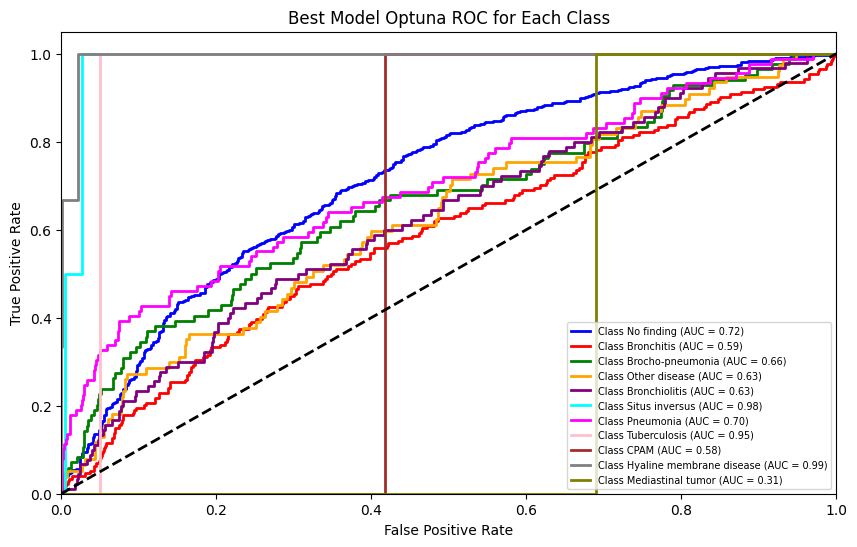

In [ ]:
test_results(best_model, test_loader, 'Best Model Optuna')

Precision: 0.5889, Recall: 0.3363, F1-Score: 0.3486
Average AUC-ROC: 0.6972


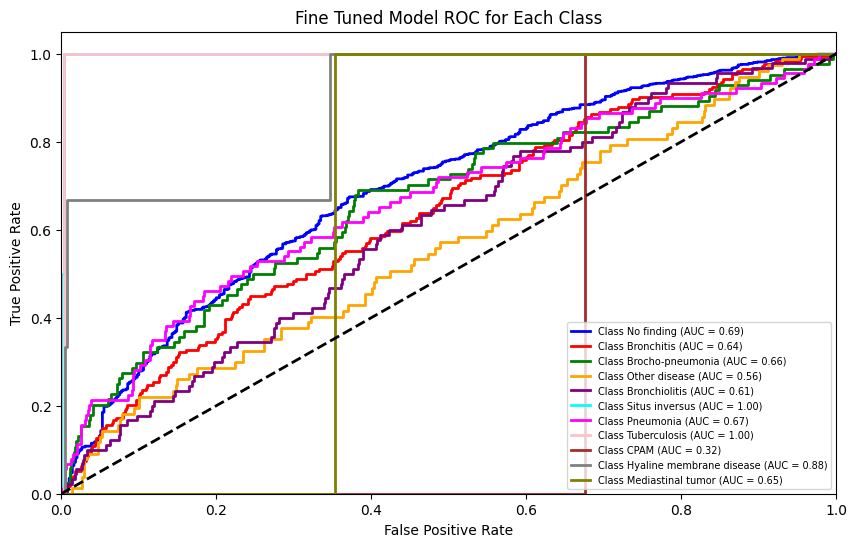

In [ ]:
test_results(tuned_model, test_loader, 'Fine Tuned Model')

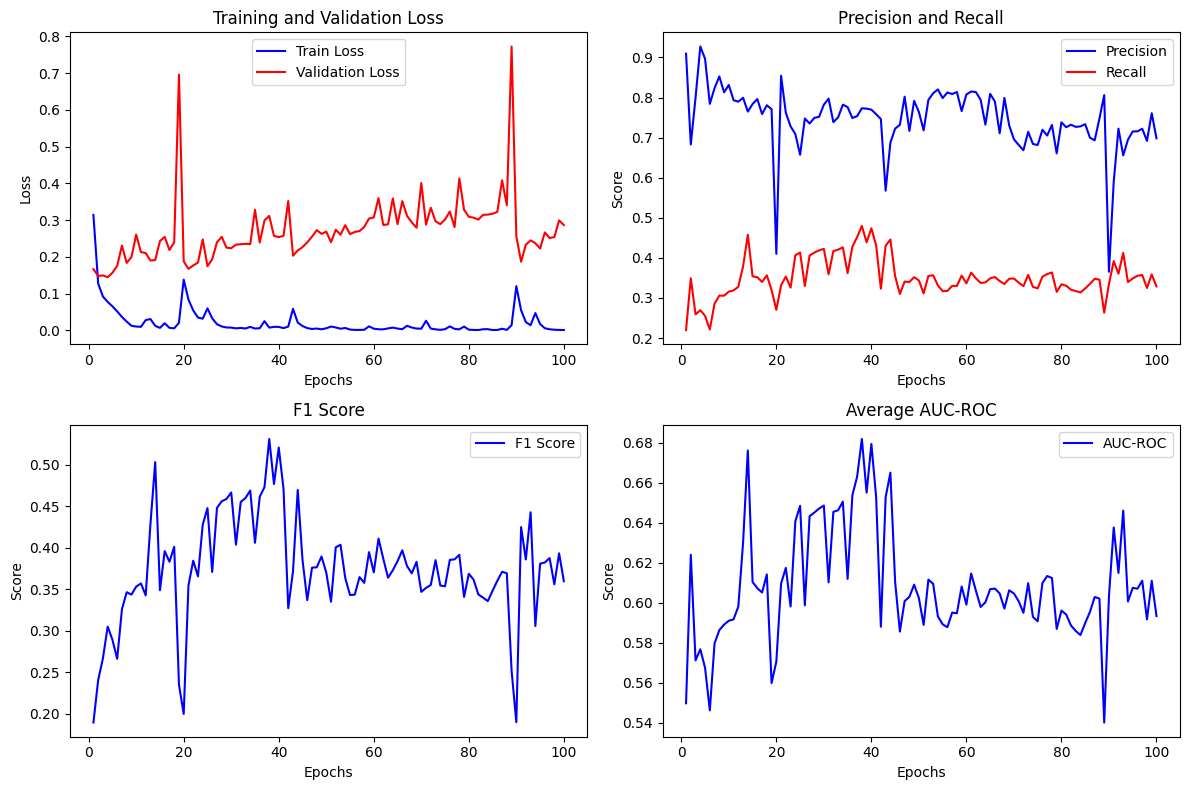

In [ ]:
file_path = '/content/drive/MyDrive/DI504 Term Project/ResNet/Fine Tuned/model_fine_tuned.json'

with open(file_path, 'r') as file:
    data = json.load(file)

# Extract data for plotting
epochs = list(range(1, len(data['train_loss']) + 1))
train_loss = data['train_loss']
val_loss = data['val_loss']
precision = data['precision']
recall = data['recall']
f1_score = data['f1']
auc_roc = data['avg_auc_roc']

# Plotting with specified color changes
plt.figure(figsize=(12, 8))

# Training and Validation Loss plot
plt.subplot(2, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Precision and Recall plot
plt.subplot(2, 2, 2)
plt.plot(epochs, precision, label='Precision', color='blue')
plt.plot(epochs, recall, label='Recall', color='red')
plt.title('Precision and Recall')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()

# F1 Score plot
plt.subplot(2, 2, 3)
plt.plot(epochs, f1_score, label='F1 Score', color='blue')
plt.title('F1 Score')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()

# Average AUC-ROC plot
plt.subplot(2, 2, 4)
plt.plot(epochs, auc_roc, label='AUC-ROC', color='blue')
plt.title('Average AUC-ROC')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()

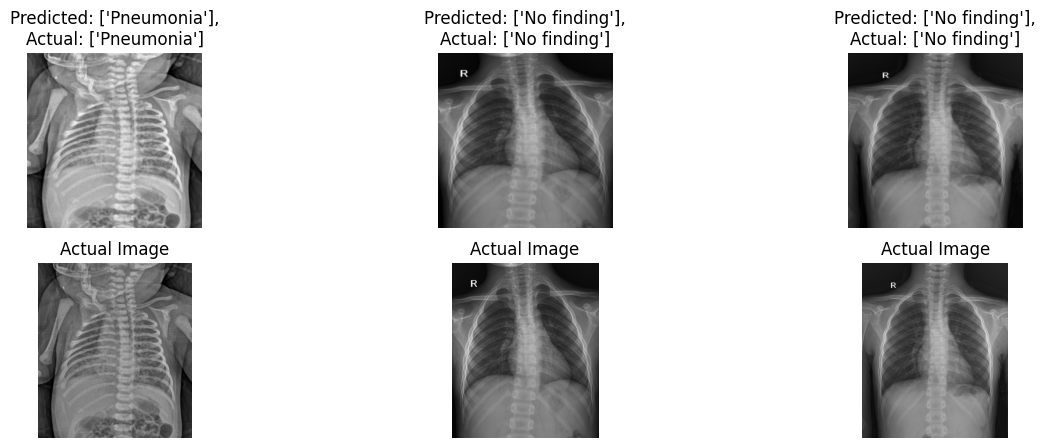

In [ ]:
sample_df = test_df.sample(3, random_state=623)
sample_loader = DataLoader(XRayDataset(sample_df), batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Label names
label_names = np.array(['No finding', 'Bronchitis', 'Brocho-pneumonia', 'Other disease',
                        'Bronchiolitis', 'Situs inversus', 'Pneumonia', 'Pleuro-pneumonia',
                        'Diagphramatic hernia', 'Tuberculosis', 'Congenital emphysema',
                        'CPAM', 'Hyaline membrane disease', 'Mediastinal tumor', 'Lung tumor'])

# Function to convert one-hot encoded vectors to label names
def one_hot_to_labels(one_hot_vector):
    indices = np.where(one_hot_vector)[0]
    return label_names[indices]

def get_image_path(image_id):
    # Replace with your actual code to get the image path
    return os.path.join('/content/data/images_resnet', image_id + '.jpg')

def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    return (image - image_min) / (image_max - image_min)

# Function to convert tensor to image
def tensor_to_image(tensor):
    return torch.permute(tensor, (1, 2, 0)).cpu().numpy()

# Get a few samples from the test dataset
images, features, ground_truth = next(iter(sample_loader))

# Get predictions
with torch.no_grad():
    images, features = images.to(device), features.to(device)
    outputs = tuned_model(images, features)
    predictions = torch.sigmoid(outputs).cpu().numpy() > 0.5

# Visualization
fig, axs = plt.subplots(2, 3, figsize=(15, 5))

# First row: display the images from the DataLoader
for i in range(3):
  normalized_image = normalize_image(tensor_to_image(images[i]))
  axs[0, i].imshow(normalized_image, cmap='gray')
  predicted_labels = one_hot_to_labels(predictions[i])
  actual_labels = one_hot_to_labels(ground_truth[i].cpu().numpy())
  axs[0, i].set_title(f"Predicted: {predicted_labels},\nActual: {actual_labels}")
  axs[0, i].axis('off')

# Second row: display the actual images using their paths
for i in range(3):
  image_id = sample_df.iloc[i]['image_id']  # Get the image ID from the same sampled dataframe
  image_path = get_image_path(image_id)  # Use the same get_image_path function
  actual_image = mpimg.imread(image_path)
  axs[1, i].imshow(actual_image, cmap='gray')
  axs[1, i].set_title("Actual Image")
  axs[1, i].axis('off')

plt.show()